# Imports

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict, LeaveOneOut, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Dados

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Partial Components Analysis'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

In [3]:
X_test, y_test = df_msc_val.iloc[:,6:], df_msc_val['SST'].values
X_train, y_train = df_msc_cal.iloc[:,6:], df_msc_cal['SST'].values

# Teste

In [13]:
# Função para calcular as métricas
def calculate_metrics(y_true, y_pred):
    correlation_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mean_y_true = np.mean(y_true)
    relative_absolute_error = 100 * (mae / np.mean(np.abs(y_true - mean_y_true)))
    root_relative_squared_error = 100 * (rmse / np.std(y_true))

    return {
        "Correlation coefficient": correlation_coefficient,
        "Mean absolute error": mae,
        "Root mean squared error": rmse,
        "Relative absolute error": relative_absolute_error,
        "Root relative squared error": root_relative_squared_error,
        "Total Number of Instances": len(y_true)
    }

def display_metrics(title, metrics):
    print(f"\n=== {title} ===")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Criar o pipeline
pipeline = make_pipeline(
    StandardScaler(),  # Normalização dos dados
    RandomForestRegressor(
        n_estimators=50,  # Número de árvores
        max_features='sqrt', # Usar raiz quadrada do número de características
        max_depth=20,    # Profundidade das árvores 
        min_samples_split=2,  # Número mínimo de amostras necessárias para dividir um nó
        min_samples_leaf=1,   # Número mínimo de amostras necessárias em um nó folha
        bootstrap=True,    # Usar amostragem bootstrap
        oob_score=False,   # Não usar amostragem fora da bolsa
        random_state=1     # Semente aleatória
    )
)

# Treinar o modelo
pipeline.fit(X_train, y_train)

# Fazer previsões no conjunto de treinamento
y_train_pred = pipeline.predict(X_train)
training_metrics = calculate_metrics(y_train, y_train_pred)
display_metrics("Training Metrics", training_metrics)

# Validação cruzada Leave-One-Out (LOO)
loo = LeaveOneOut()
y_train_cv = cross_val_predict(pipeline, X_train, y_train, cv=loo)
cv_metrics = calculate_metrics(y_train, y_train_cv)
display_metrics("Cross-Validation Metrics", cv_metrics)

# Avaliação final no conjunto de teste
y_pred_val = pipeline.predict(X_test)
validation_metrics = calculate_metrics(y_test, y_pred_val)
display_metrics("Validation Metrics", validation_metrics)


=== Training Metrics ===
Correlation coefficient: 0.9795
Mean absolute error: 0.4611
Root mean squared error: 0.5823
Relative absolute error: 20.8848
Root relative squared error: 21.9223
Total Number of Instances: 175.0000

=== Cross-Validation Metrics ===
Correlation coefficient: 0.8121
Mean absolute error: 1.2309
Root mean squared error: 1.5508
Relative absolute error: 55.7481
Root relative squared error: 58.3798
Total Number of Instances: 175.0000

=== Validation Metrics ===
Correlation coefficient: 0.8218
Mean absolute error: 0.9881
Root mean squared error: 1.2083
Relative absolute error: 57.3276
Root relative squared error: 57.4173
Total Number of Instances: 75.0000


# Algoritmo

In [4]:
def RFR(X_cal, y_cal, X_val, y_val, filter, attribute):
    # Função para calcular as métricas
    def calculate_metrics(y_true, y_pred):
        correlation_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mean_y_true = np.mean(y_true)
        relative_absolute_error = 100 * (mae / np.mean(np.abs(y_true - mean_y_true)))
        root_relative_squared_error = 100 * (rmse / np.std(y_true))

        return {
            "Correlation coefficient": correlation_coefficient,
            "Mean absolute error": mae,
            "Root mean squared error": rmse,
            "Relative absolute error": relative_absolute_error,
            "Root relative squared error": root_relative_squared_error,
            "Total Number of Instances": len(y_true)
        }

    def display_metrics(title, metrics):
        print(f"\n=== {title} ===")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    # Definir variáveis de treino e teste para o atributo atual
    X_train, y_train = X_cal, y_cal
    X_test, y_test = X_val, y_val

    # Criar o pipeline
    pipeline = make_pipeline(
        StandardScaler(),  # Normalização dos dados
        RandomForestRegressor(
            n_estimators=50,  # Número de árvores
            max_features='sqrt', # Usar raiz quadrada do número de características
            max_depth=20,    # Profundidade das árvores
            min_samples_split=2,  # Número mínimo de amostras necessárias para dividir um nó
            min_samples_leaf=1,   # Número mínimo de amostras necessárias em um nó folha
            bootstrap=True,    # Usar amostragem bootstrap
            oob_score=False,   # Não usar amostragem fora da bolsa
            random_state=1     # Semente aleatória
        )
    )

    # Treinar o modelo
    pipeline.fit(X_train, y_train)

    # Fazer previsões no conjunto de treinamento
    y_train_pred = pipeline.predict(X_train)
    training_metrics = calculate_metrics(y_train, y_train_pred)
    display_metrics("Training Metrics", training_metrics)

    # Validação cruzada Leave-One-Out (LOO)
    loo = LeaveOneOut()
    y_train_cv = cross_val_predict(pipeline, X_train, y_train, cv=loo)
    cv_metrics = calculate_metrics(y_train, y_train_cv)
    display_metrics("Cross-Validation Metrics", cv_metrics)

    # Avaliação final no conjunto de teste
    y_pred_val = pipeline.predict(X_test)
    validation_metrics = calculate_metrics(y_test, y_pred_val)
    display_metrics("Validation Metrics", validation_metrics)

    results = []
    
    # Adicionar resultados à lista
    results.append({
        'Attribute': attribute,
        'Training Correlation': training_metrics['Correlation coefficient'],
        'Training MAE': training_metrics['Mean absolute error'],
        'Training RMSE': training_metrics['Root mean squared error'],
        'Training Relative MAE': training_metrics['Relative absolute error'],
        'Training Root Relative RMSE': training_metrics['Root relative squared error'],
        'CV Correlation': cv_metrics['Correlation coefficient'],
        'CV MAE': cv_metrics['Mean absolute error'],
        'CV RMSE': cv_metrics['Root mean squared error'],
        'CV Relative MAE': cv_metrics['Relative absolute error'],
        'CV Root Relative RMSE': cv_metrics['Root relative squared error'],
        'Validation Correlation': validation_metrics['Correlation coefficient'],
        'Validation MAE': validation_metrics['Mean absolute error'],
        'Validation RMSE': validation_metrics['Root mean squared error'],
        'Validation Relative MAE': validation_metrics['Relative absolute error'],
        'Validation Root Relative RMSE': validation_metrics['Root relative squared error']
    })

    # Converter os resultados para um DataFrame
    results_df = pd.DataFrame(results)
    
    def plot_regression_comparison(y_train, y_pred_train, y_pred_cv):
        def plot_with_regression(ax, y_true, y_pred, title):
            # Calcular slope, offset, R² e RMSE
            model = LinearRegression().fit(y_pred.reshape(-1, 1), y_true)
            slope = model.coef_[0]
            offset = model.intercept_
            y_pred_line = model.predict(np.array([y_true.min(), y_true.max()]).reshape(-1, 1))
            r2 = r2_score(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))

            # Plotar os dados
            ax.scatter(y_pred, y_true, label='Dados', color='blue')
            ax.plot([y_true.min(), y_true.max()], y_pred_line, color='red', linestyle='--', label='Linha de Regressão')
            ax.set_xlabel('Predito')
            ax.set_ylabel('Real')
            ax.set_title(title)
            ax.legend()
            ax.text(0.05, 0.95, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
                    transform=ax.transAxes, verticalalignment='top')

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
        
        plot_with_regression(axs[0], y_train, y_pred_train, 'Treinamento')
        plot_with_regression(axs[1], y_train, y_pred_cv, 'Validação Cruzada')
        
        plt.tight_layout()
        plt.show()

    # Plotar comparação entre valores reais e preditos
    plot_regression_comparison(y_train, y_train_pred, y_train_cv)
    
    def plot_test_predictions(y_true_test, y_pred_test):
        # Calcular slope, offset, R² e RMSE
        model = LinearRegression().fit(y_pred_test.reshape(-1, 1), y_true_test)
        slope = model.coef_[0]
        offset = model.intercept_
        y_pred_line = model.predict(np.array([y_true_test.min(), y_true_test.max()]).reshape(-1, 1))
        r2 = r2_score(y_true_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, y_true_test, color='blue', label='Dados')
        plt.plot([y_true_test.min(), y_true_test.max()], y_pred_line, color='red', linestyle='--', label='Linha de Regressão')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.title('Predições no Conjunto de Teste')
        plt.legend()
        plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
                transform=plt.gca().transAxes, verticalalignment='top')
        plt.tight_layout()
        plt.show()

    # Plotar as predições do conjunto de teste
    plot_test_predictions(y_test, y_pred_val)
    
    return results_df


# Ajusta saída

In [7]:
def save_results(filter, attribute, results_df):
    # Definir o nome do arquivo com base no filtro e atributo
    filename = f'random_forest_results.xlsx'
    
    # Definir o nome da aba
    sheet_name = f'{filter}_{attribute}'
    
    # Usar ExcelWriter para adicionar ou criar o arquivo e a nova aba
    with pd.ExcelWriter(filename, engine='openpyxl', mode='a' if os.path.exists(filename) else 'w') as writer:
        results_df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    print(f'Resultados salvos em: {filename}, na aba: {sheet_name}')


# MSC - RFR


=== Training Metrics ===
Correlation coefficient: 0.9795
Mean absolute error: 0.4611
Root mean squared error: 0.5823
Relative absolute error: 20.8848
Root relative squared error: 21.9223
Total Number of Instances: 175.0000

=== Cross-Validation Metrics ===
Correlation coefficient: 0.8121
Mean absolute error: 1.2309
Root mean squared error: 1.5508
Relative absolute error: 55.7481
Root relative squared error: 58.3798
Total Number of Instances: 175.0000

=== Validation Metrics ===
Correlation coefficient: 0.8218
Mean absolute error: 0.9881
Root mean squared error: 1.2083
Relative absolute error: 57.3276
Root relative squared error: 57.4173
Total Number of Instances: 75.0000


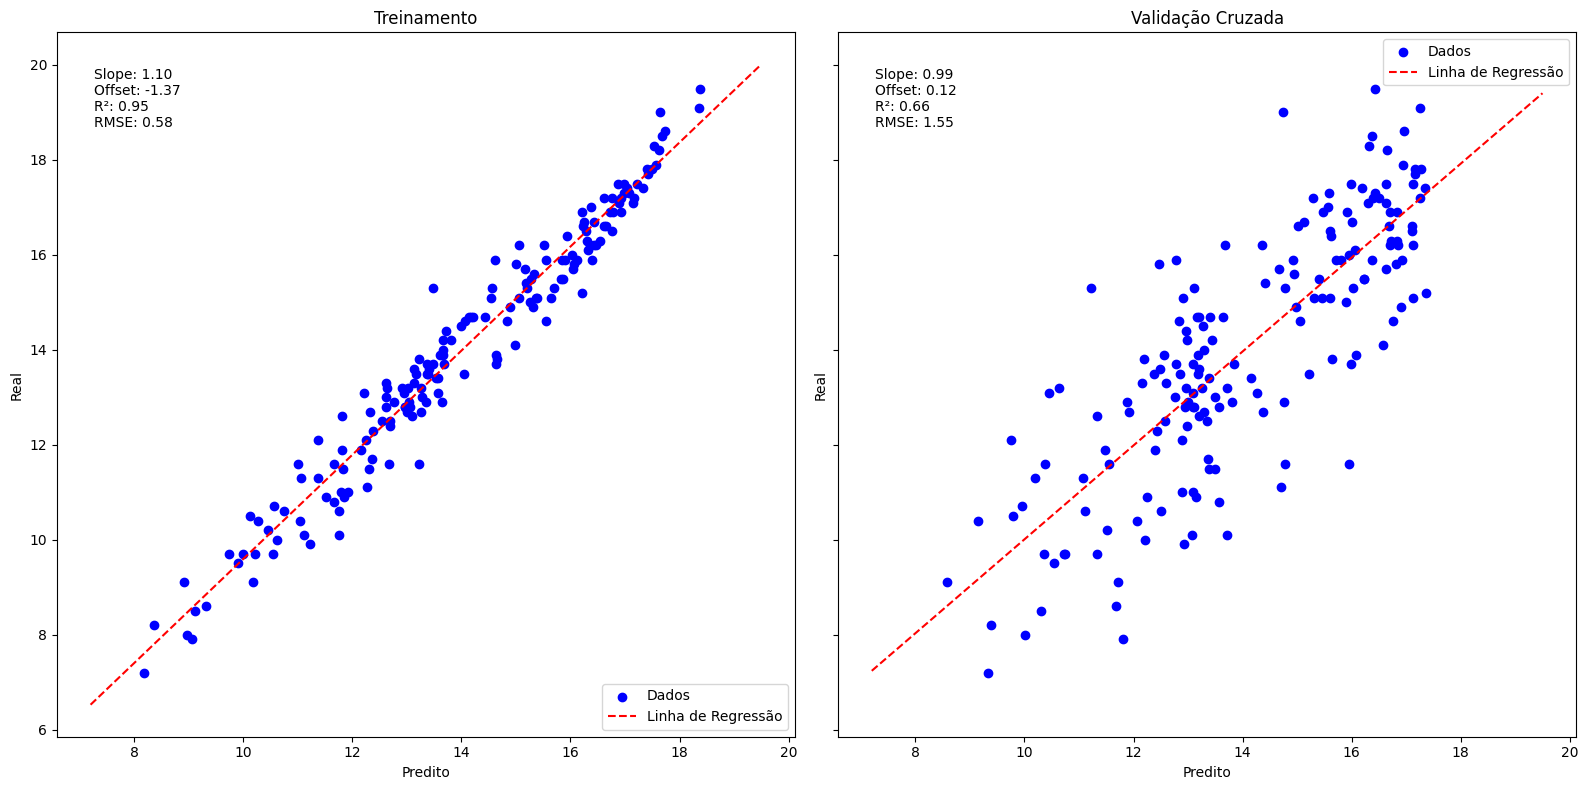

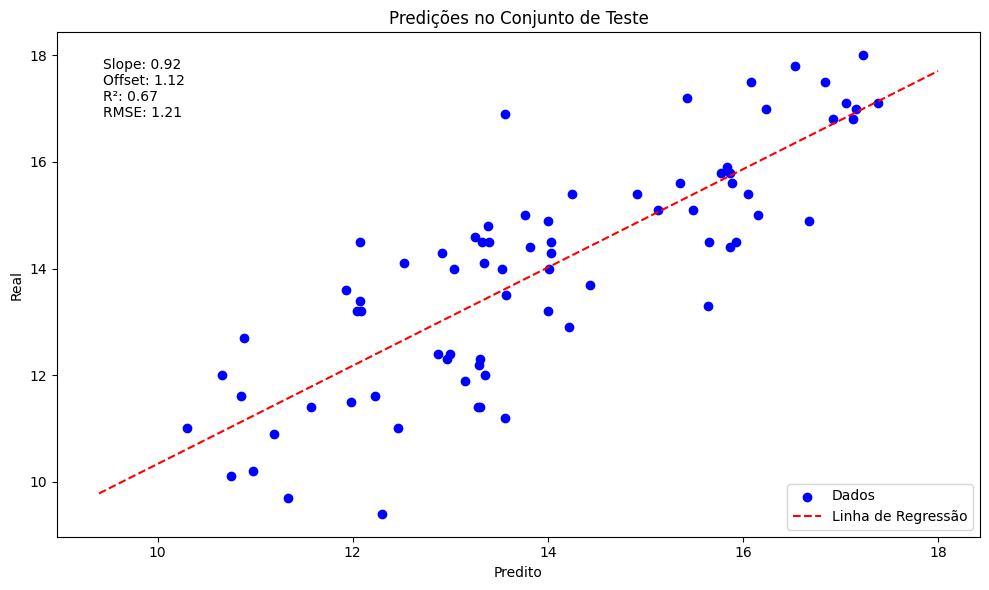

Resultados salvos em: random_forest_results.xlsx, na aba: MSC_SST


In [8]:
results_msc_sst = RFR(df_msc_cal.iloc[:, 6:], df_msc_cal['SST'].values, df_msc_val.iloc[:, 6:], df_msc_val['SST'].values, 'MSC', 'SST')
save_results('MSC', 'SST', results_msc_sst)


=== Training Metrics ===
Correlation coefficient: 0.9570
Mean absolute error: 0.0945
Root mean squared error: 0.1881
Relative absolute error: 20.9072
Root relative squared error: 32.0702
Total Number of Instances: 175.0000

=== Cross-Validation Metrics ===
Correlation coefficient: 0.6509
Mean absolute error: 0.2600
Root mean squared error: 0.4466
Relative absolute error: 57.5414
Root relative squared error: 76.1635
Total Number of Instances: 175.0000

=== Validation Metrics ===
Correlation coefficient: 0.7350
Mean absolute error: 0.2157
Root mean squared error: 0.3085
Relative absolute error: 60.6645
Root relative squared error: 70.5393
Total Number of Instances: 75.0000


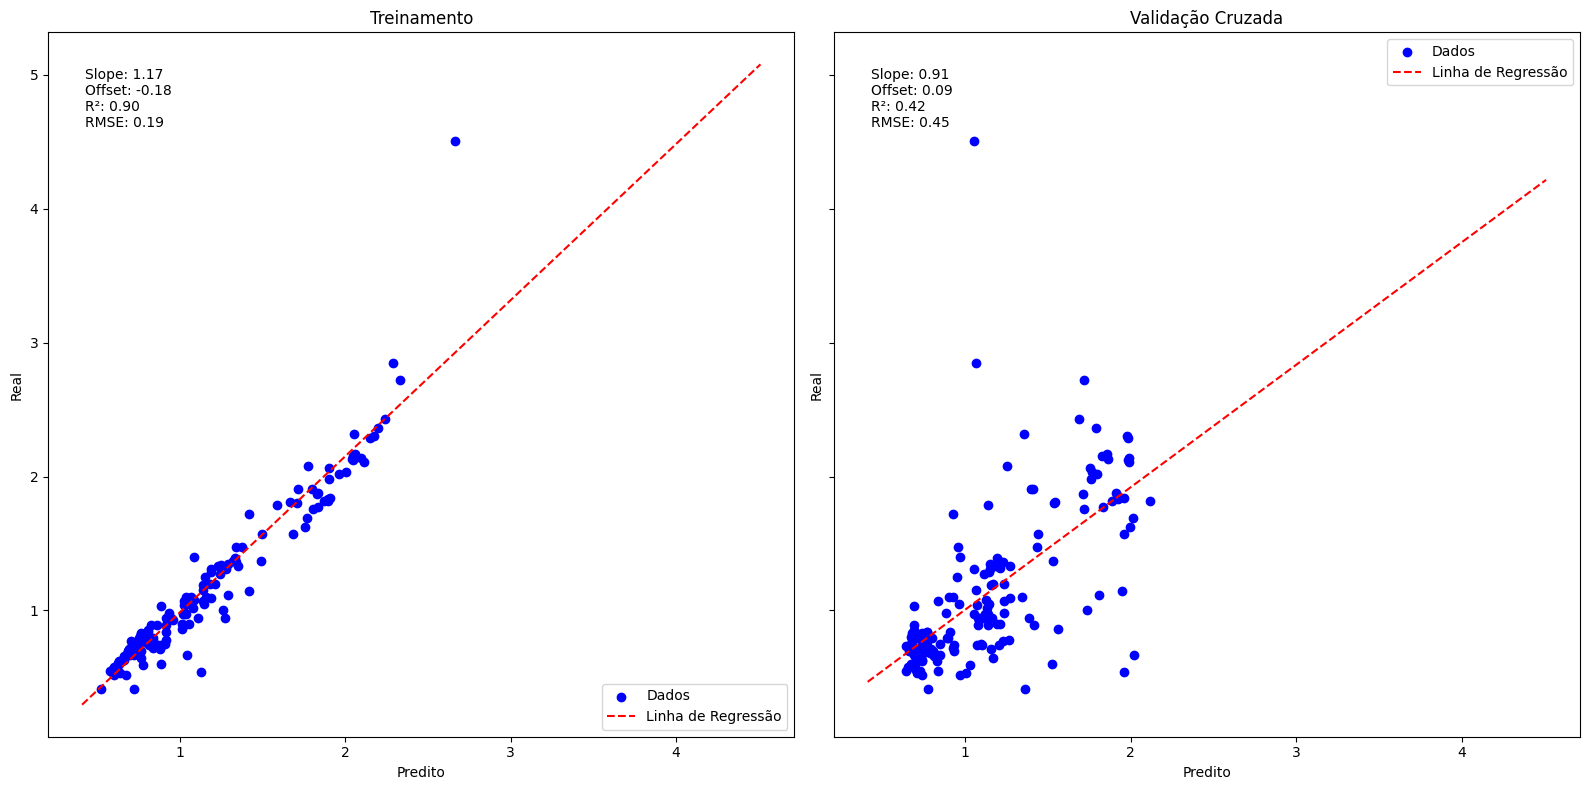

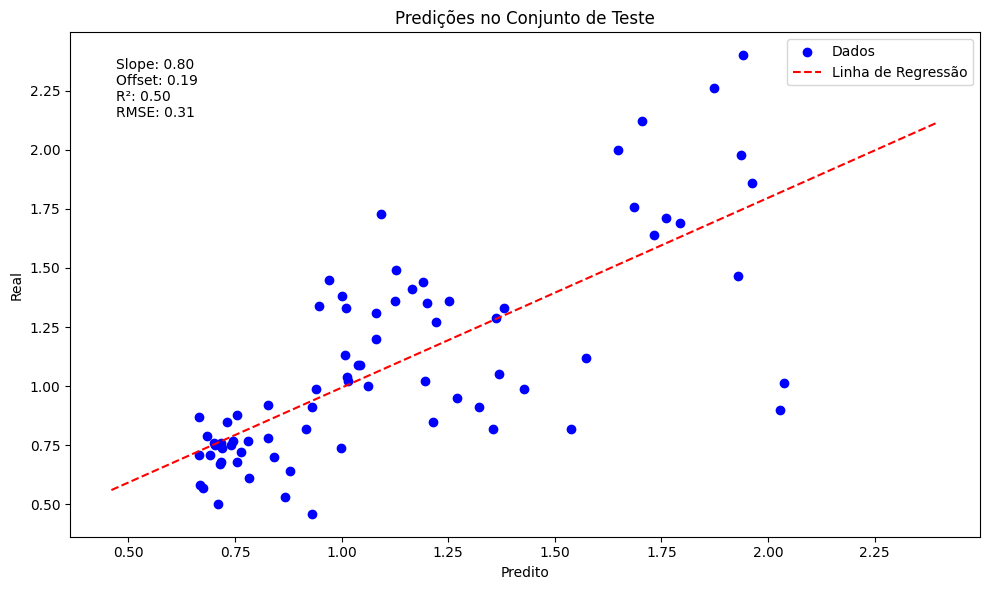

Resultados salvos em: random_forest_results.xlsx, na aba: MSC_AT


In [9]:
results_msc_at = RFR(df_msc_cal.iloc[:, 6:], df_msc_cal['AT'].values, df_msc_val.iloc[:, 6:], df_msc_val['AT'].values, 'MSC', 'AT')
save_results('MSC', 'AT', results_msc_at)


=== Training Metrics ===
Correlation coefficient: 0.9663
Mean absolute error: 0.0578
Root mean squared error: 0.0940
Relative absolute error: 24.0813
Root relative squared error: 30.4739
Total Number of Instances: 175.0000

=== Cross-Validation Metrics ===
Correlation coefficient: 0.5569
Mean absolute error: 0.1520
Root mean squared error: 0.2569
Relative absolute error: 63.3683
Root relative squared error: 83.3006
Total Number of Instances: 175.0000

=== Validation Metrics ===
Correlation coefficient: 0.4707
Mean absolute error: 0.1774
Root mean squared error: 0.2701
Relative absolute error: 75.2885
Root relative squared error: 102.5066
Total Number of Instances: 75.0000


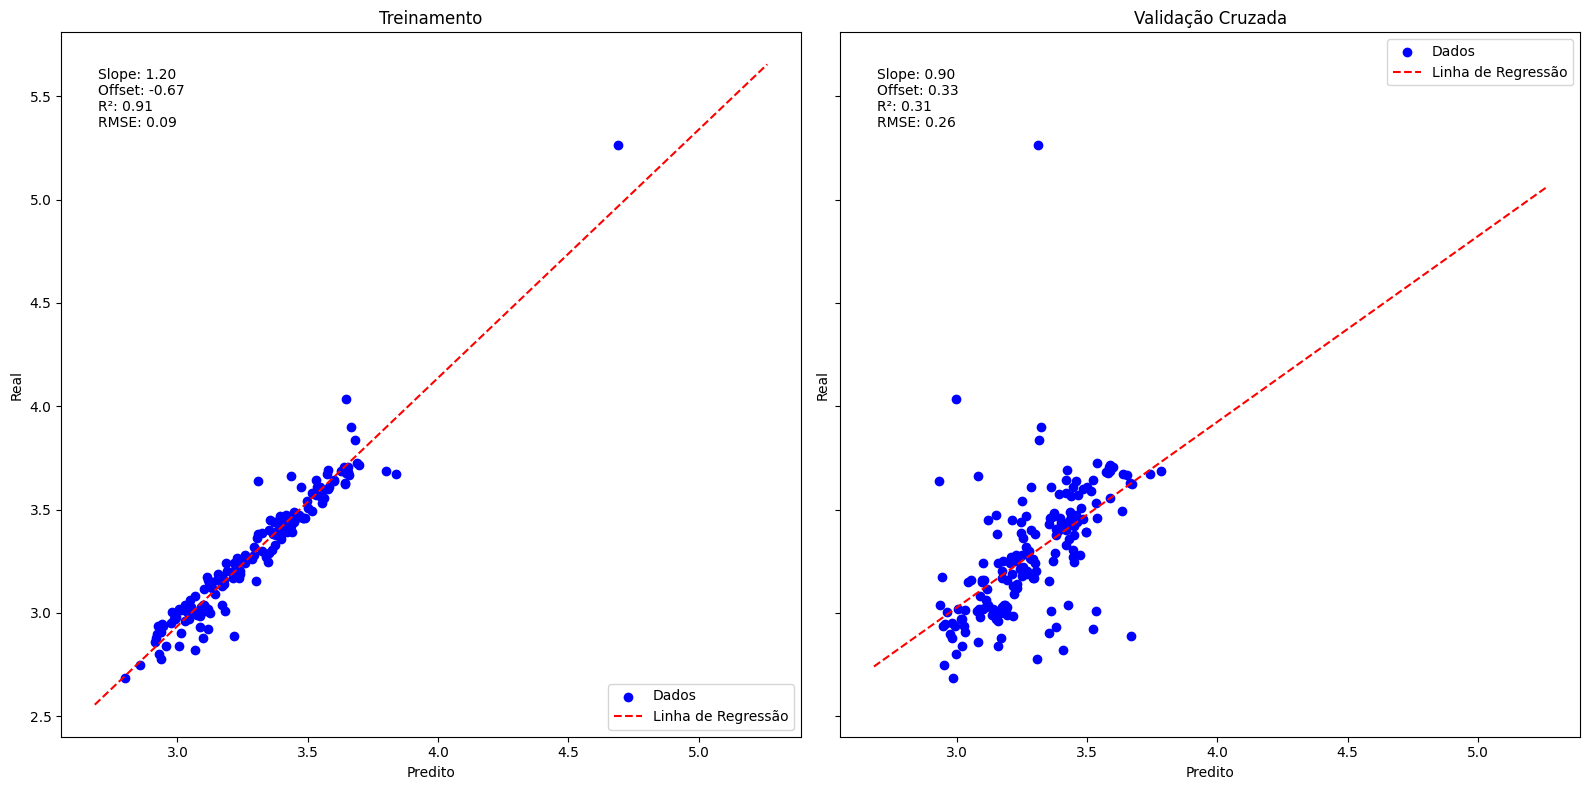

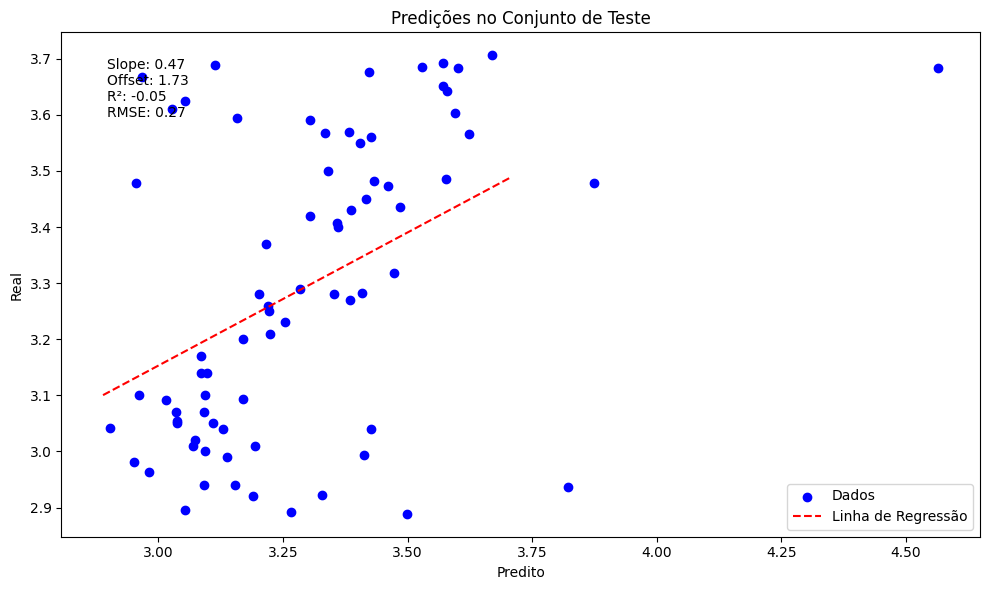

Resultados salvos em: random_forest_results.xlsx, na aba: MSC_PH


In [10]:
results_msc_ph = RFR(df_msc_cal.iloc[:, 6:], df_msc_cal['PH'].values, df_msc_val.iloc[:, 6:], df_msc_val['PH'].values, 'MSC', 'PH')
save_results('MSC', 'PH', results_msc_ph)



=== Training Metrics ===
Correlation coefficient: 0.9667
Mean absolute error: 22.7860
Root mean squared error: 29.4504
Relative absolute error: 27.3643
Root relative squared error: 28.6566
Total Number of Instances: 175.0000

=== Cross-Validation Metrics ===
Correlation coefficient: 0.6764
Mean absolute error: 61.0032
Root mean squared error: 75.8255
Relative absolute error: 73.2603
Root relative squared error: 73.7817
Total Number of Instances: 175.0000

=== Validation Metrics ===
Correlation coefficient: 0.7176
Mean absolute error: 46.3544
Root mean squared error: 56.6345
Relative absolute error: 73.0317
Root relative squared error: 73.3081
Total Number of Instances: 75.0000


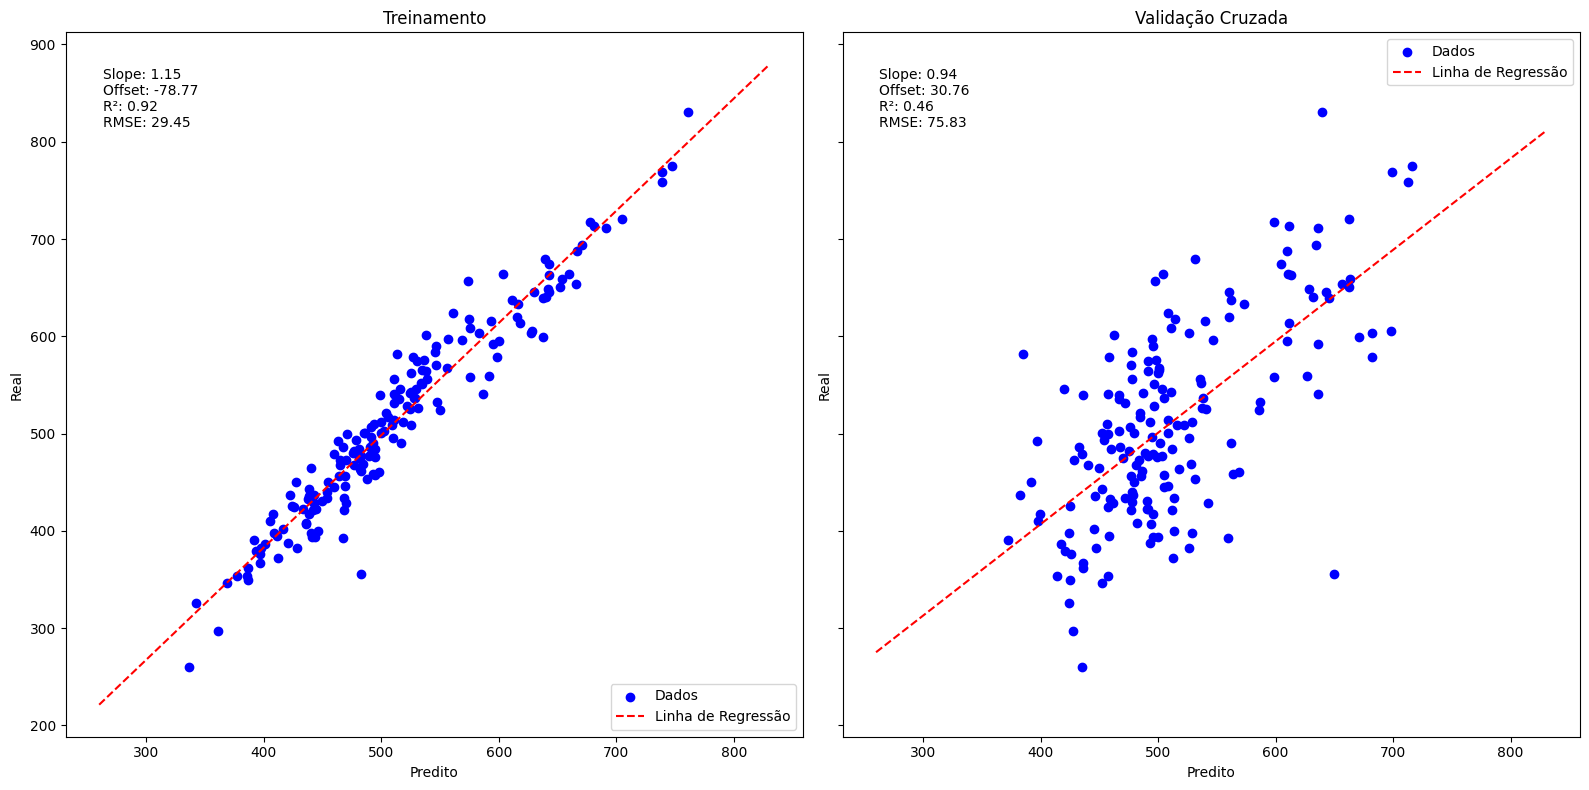

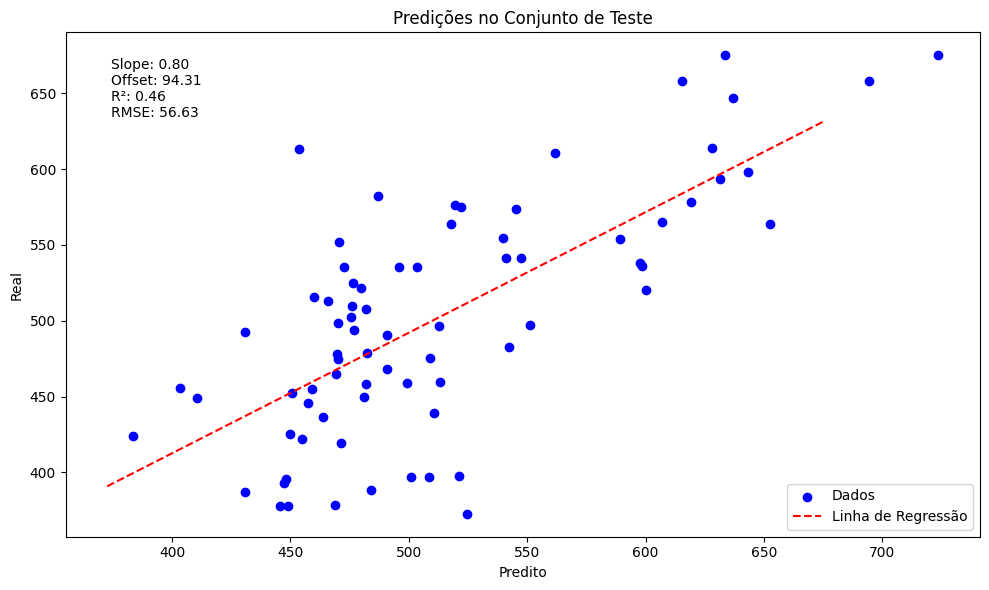

Resultados salvos em: random_forest_results.xlsx, na aba: MSC_FIRMEZA


In [11]:
results_msc_f = RFR(df_msc_cal.iloc[:, 6:], df_msc_cal['FIRMEZA (N)'].values, df_msc_val.iloc[:, 6:], df_msc_val['FIRMEZA (N)'].values, 'MSC', 'FIRMEZA (N)')
save_results('MSC', 'FIRMEZA', results_msc_f)


=== Training Metrics ===
Correlation coefficient: 0.9741
Mean absolute error: 0.4829
Root mean squared error: 0.8025
Relative absolute error: 19.5452
Root relative squared error: 24.9459
Total Number of Instances: 175.0000

=== Cross-Validation Metrics ===
Correlation coefficient: 0.7693
Mean absolute error: 1.2599
Root mean squared error: 2.0555
Relative absolute error: 50.9935
Root relative squared error: 63.8971
Total Number of Instances: 175.0000

=== Validation Metrics ===
Correlation coefficient: 0.8214
Mean absolute error: 1.0463
Root mean squared error: 1.4112
Relative absolute error: 58.9359
Root relative squared error: 65.1187
Total Number of Instances: 75.0000


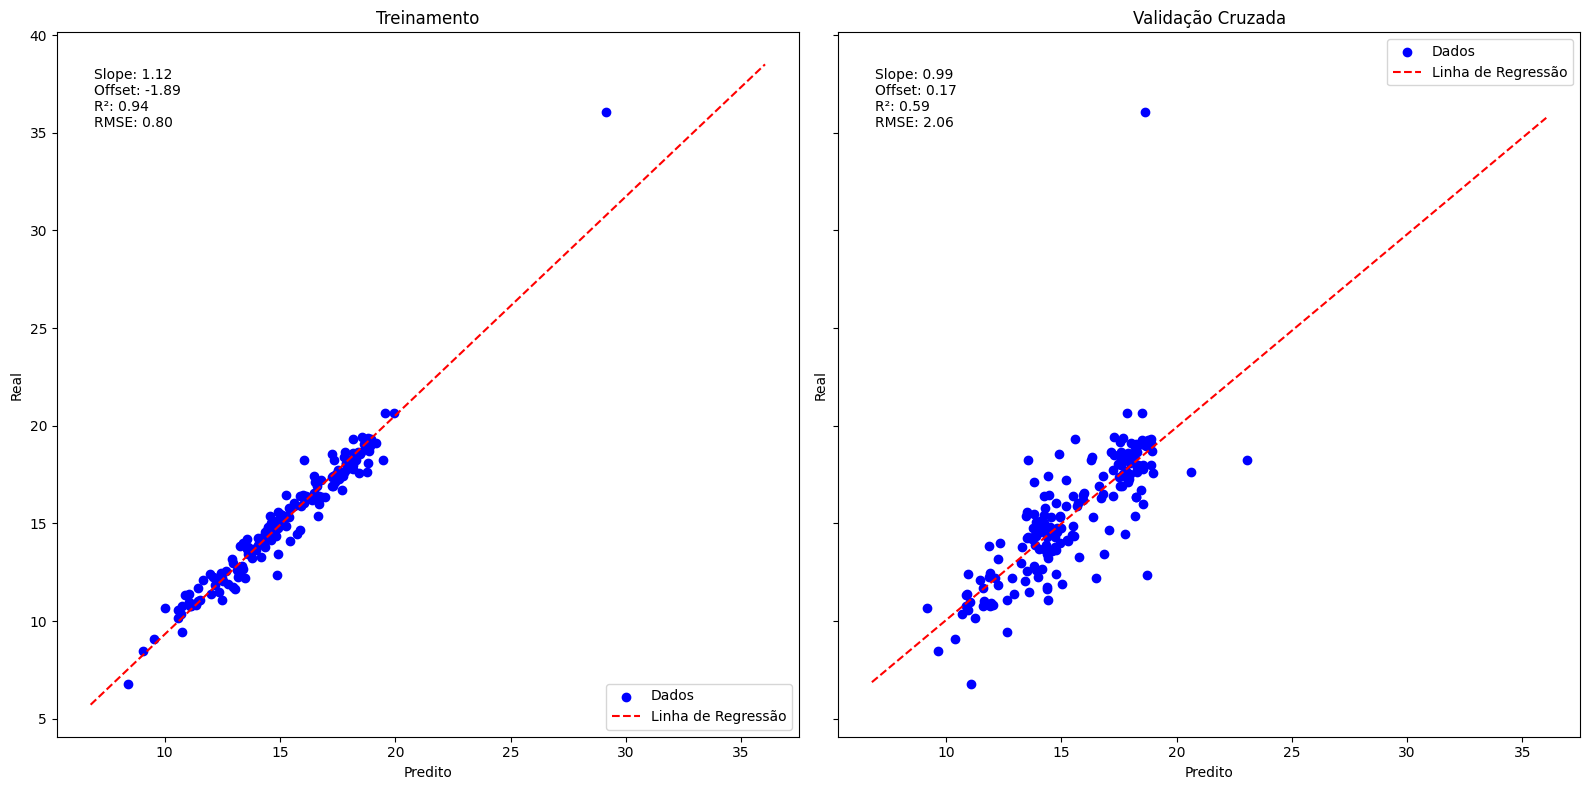

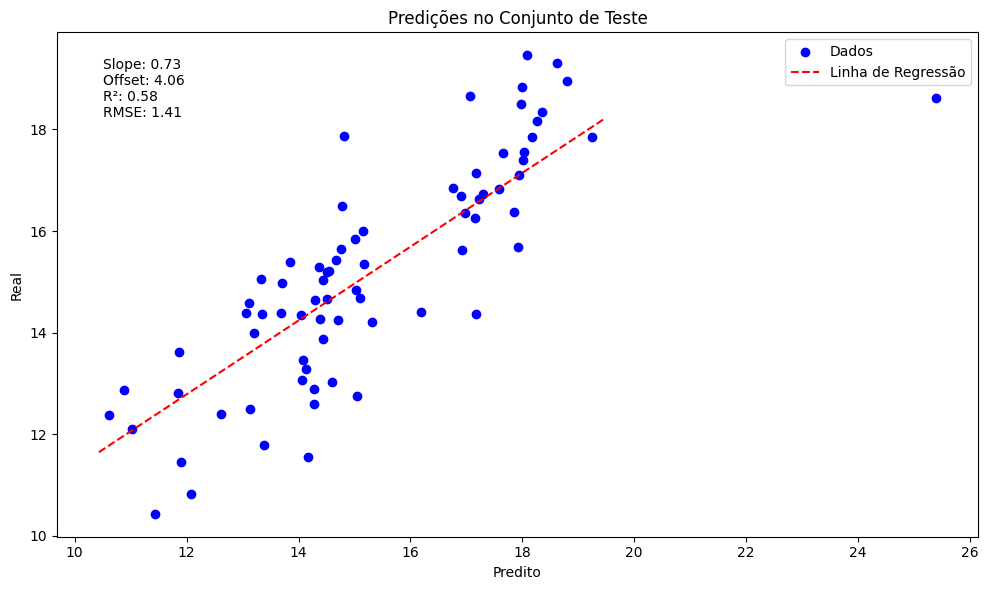

Resultados salvos em: random_forest_results.xlsx, na aba: MSC_UBS


In [12]:
results_msc_ubs = RFR(df_msc_cal.iloc[:, 6:], df_msc_cal['UBS (%)'].values, df_msc_val.iloc[:, 6:], df_msc_val['UBS (%)'].values, 'MSC', 'UBS (%)')
save_results('MSC', 'UBS', results_msc_ubs)

# SNV - RFR


=== Training Metrics ===
Correlation coefficient: 0.9774
Mean absolute error: 0.4507
Root mean squared error: 0.5751
Relative absolute error: 21.0561
Root relative squared error: 22.0942
Total Number of Instances: 175.0000

=== Cross-Validation Metrics ===
Correlation coefficient: 0.8265
Mean absolute error: 1.1665
Root mean squared error: 1.4674
Relative absolute error: 54.4933
Root relative squared error: 56.3778
Total Number of Instances: 175.0000

=== Validation Metrics ===
Correlation coefficient: 0.8366
Mean absolute error: 0.9880
Root mean squared error: 1.3013
Relative absolute error: 53.1519
Root relative squared error: 57.9255
Total Number of Instances: 75.0000


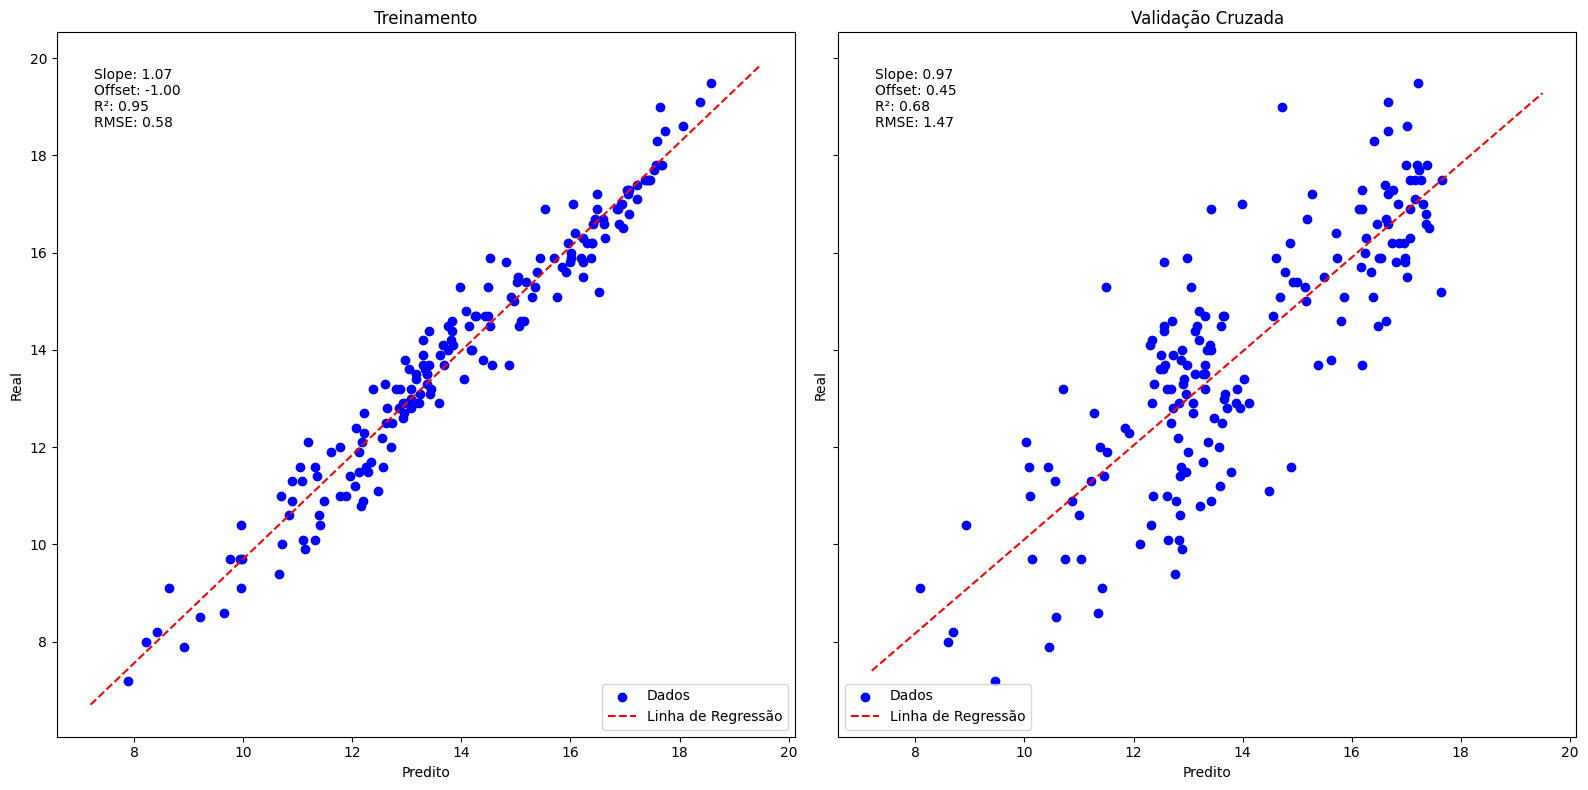

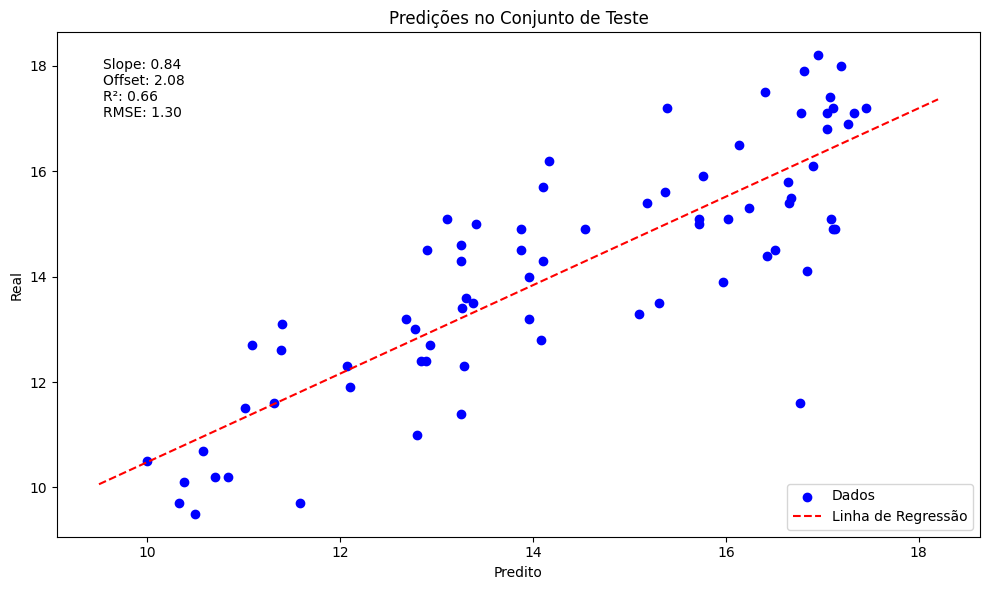

Resultados salvos em: random_forest_results.xlsx, na aba: SNV_SST


In [13]:
results_snv_sst = RFR(df_snv_cal.iloc[:, 6:], df_snv_cal['SST'].values, df_snv_val.iloc[:, 6:], df_snv_val['SST'].values, 'SNV', 'SST')
save_results('SNV', 'SST', results_snv_sst)


=== Training Metrics ===
Correlation coefficient: 0.9656
Mean absolute error: 0.0977
Root mean squared error: 0.1627
Relative absolute error: 23.1198
Root relative squared error: 29.0984
Total Number of Instances: 175.0000

=== Cross-Validation Metrics ===
Correlation coefficient: 0.5975
Mean absolute error: 0.2633
Root mean squared error: 0.4542
Relative absolute error: 62.3310
Root relative squared error: 81.2185
Total Number of Instances: 175.0000

=== Validation Metrics ===
Correlation coefficient: 0.8326
Mean absolute error: 0.1839
Root mean squared error: 0.2853
Relative absolute error: 43.7531
Root relative squared error: 55.5554
Total Number of Instances: 75.0000


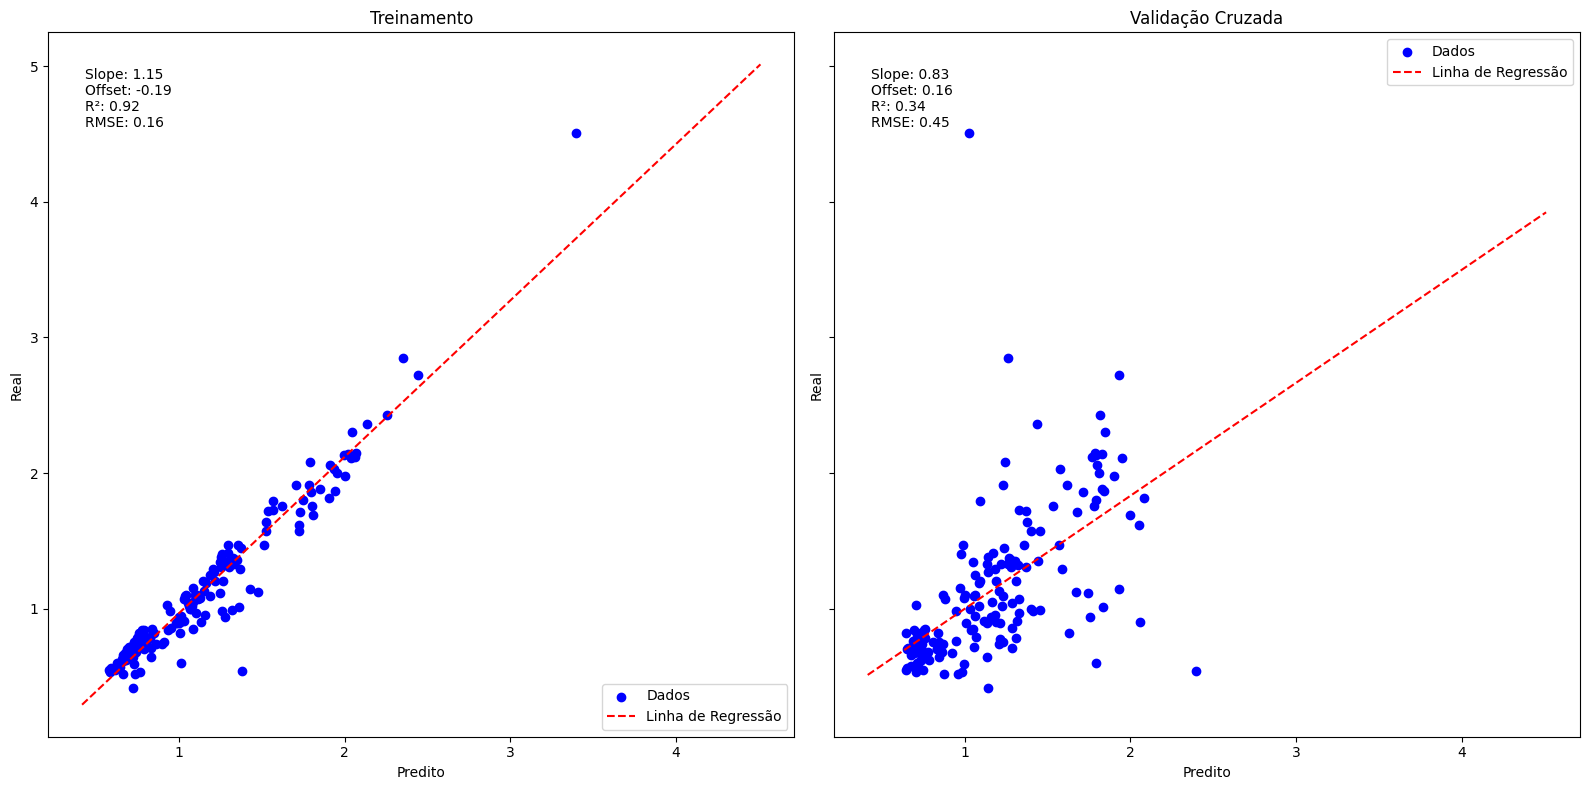

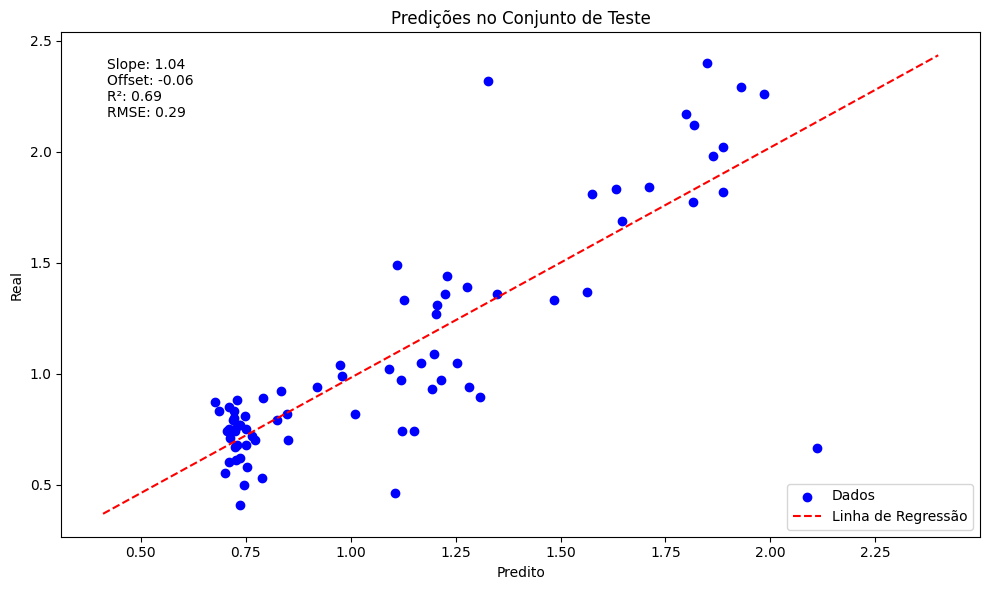

Resultados salvos em: random_forest_results.xlsx, na aba: SNV_AT


In [14]:
results_snv_at = RFR(df_snv_cal.iloc[:, 6:], df_snv_cal['AT'].values, df_snv_val.iloc[:, 6:], df_snv_val['AT'].values, 'SNV', 'AT')
save_results('SNV', 'AT', results_snv_at)


=== Training Metrics ===
Correlation coefficient: 0.9660
Mean absolute error: 0.0616
Root mean squared error: 0.0941
Relative absolute error: 24.7741
Root relative squared error: 30.0520
Total Number of Instances: 175.0000

=== Cross-Validation Metrics ===
Correlation coefficient: 0.5448
Mean absolute error: 0.1655
Root mean squared error: 0.2658
Relative absolute error: 66.5455
Root relative squared error: 84.8967
Total Number of Instances: 175.0000

=== Validation Metrics ===
Correlation coefficient: 0.6809
Mean absolute error: 0.1189
Root mean squared error: 0.1840
Relative absolute error: 56.1584
Root relative squared error: 74.5198
Total Number of Instances: 75.0000


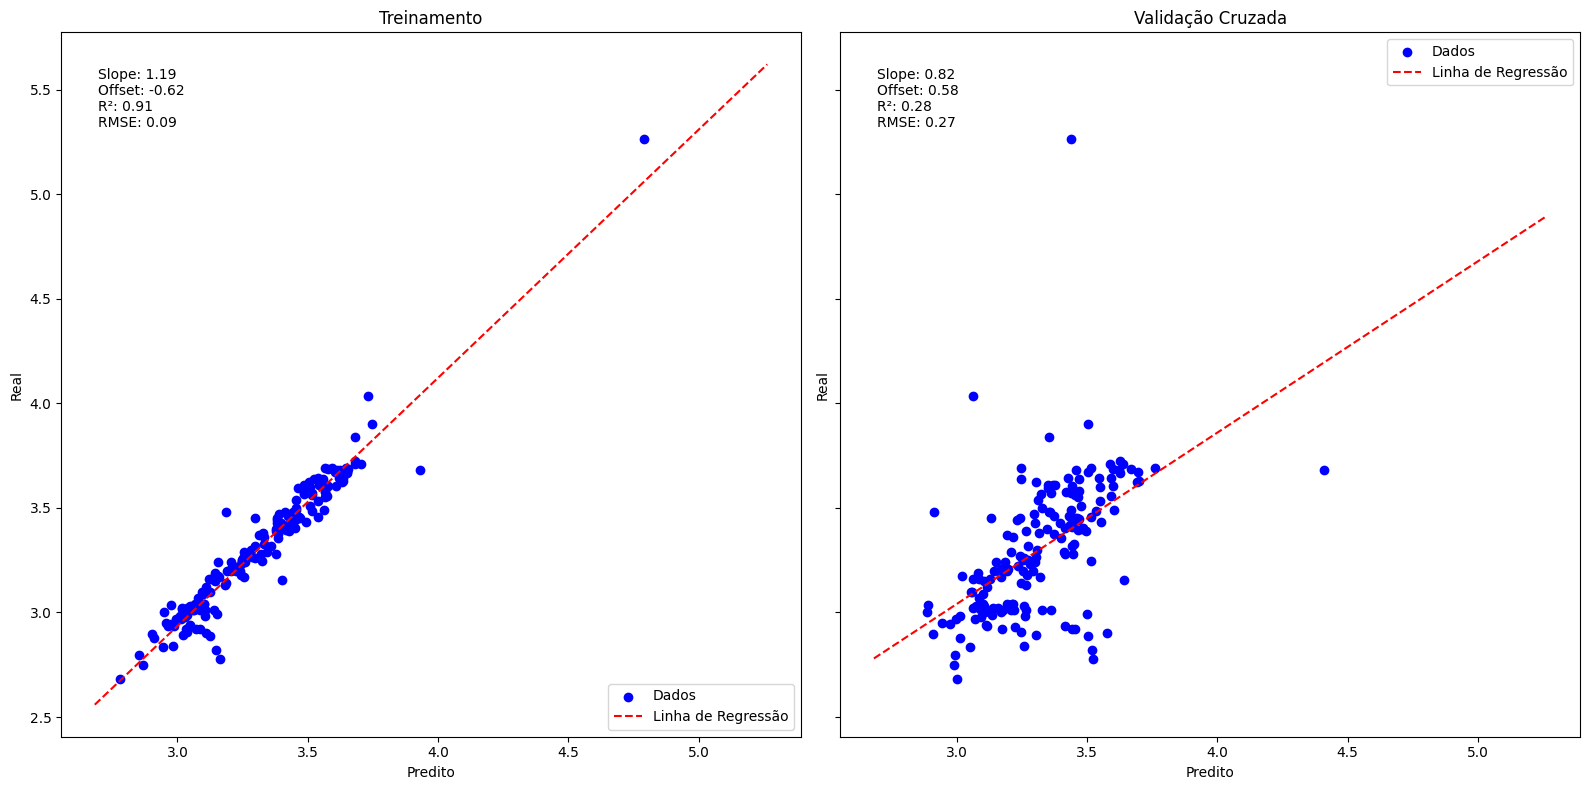

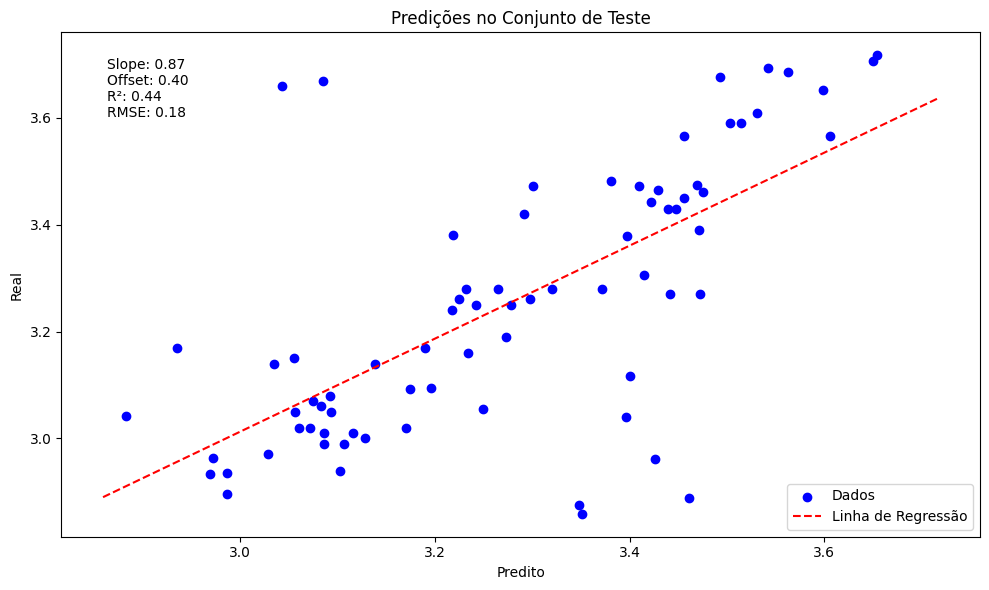

Resultados salvos em: random_forest_results.xlsx, na aba: SNV_PH


In [15]:
results_snv_ph = RFR(df_snv_cal.iloc[:, 6:], df_snv_cal['PH'].values, df_snv_val.iloc[:, 6:], df_snv_val['PH'].values, 'SNV', 'PH')
save_results('SNV', 'PH', results_snv_ph)


=== Training Metrics ===
Correlation coefficient: 0.9713
Mean absolute error: 22.8039
Root mean squared error: 28.9041
Relative absolute error: 28.1958
Root relative squared error: 28.5925
Total Number of Instances: 175.0000

=== Cross-Validation Metrics ===
Correlation coefficient: 0.5994
Mean absolute error: 65.9905
Root mean squared error: 81.6180
Relative absolute error: 81.5937
Root relative squared error: 80.7380
Total Number of Instances: 175.0000

=== Validation Metrics ===
Correlation coefficient: 0.7799
Mean absolute error: 45.3109
Root mean squared error: 52.6513
Relative absolute error: 67.5382
Root relative squared error: 64.3175
Total Number of Instances: 75.0000


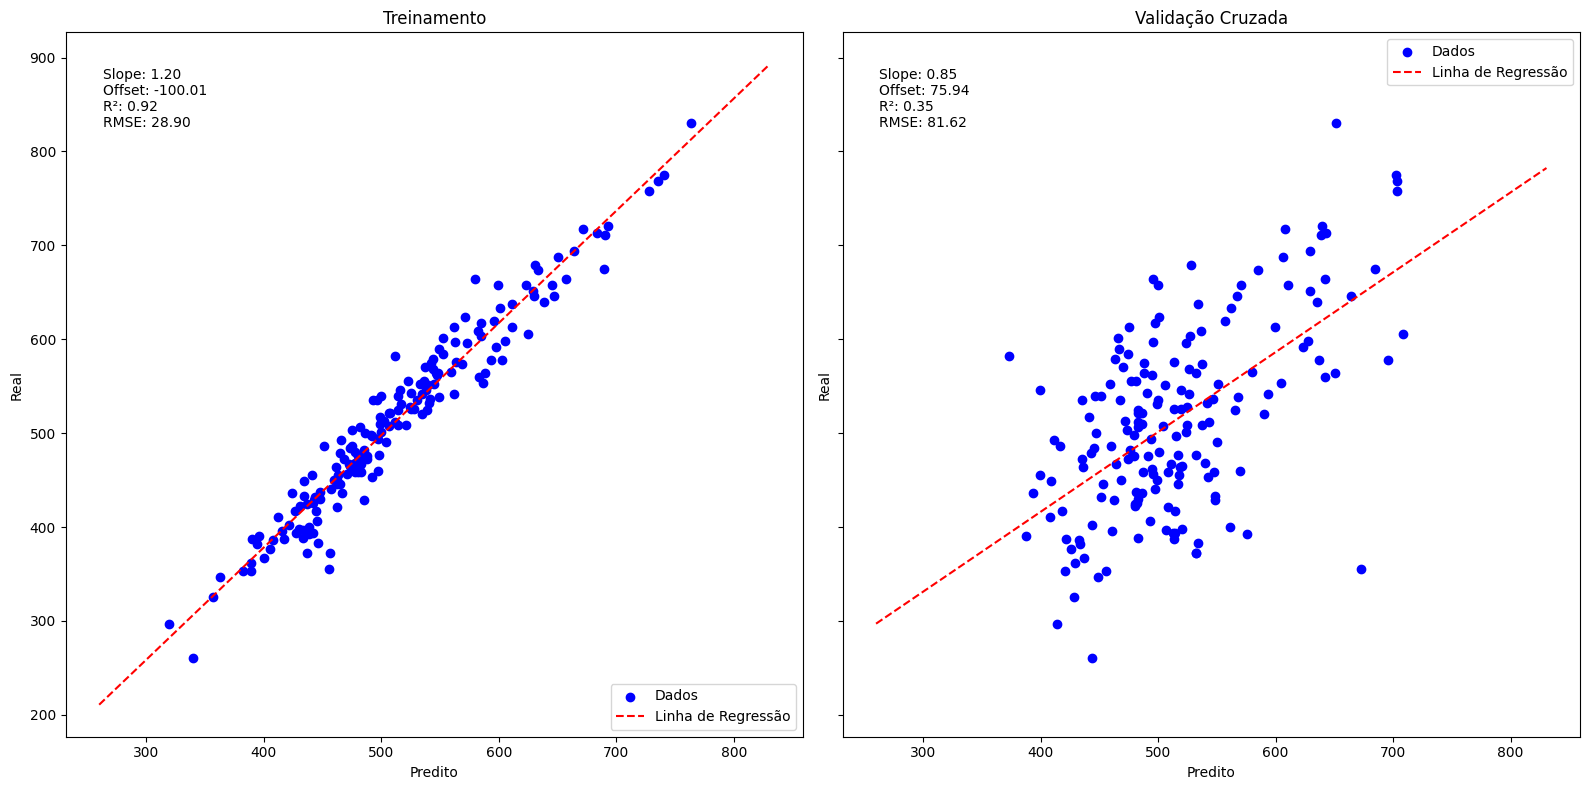

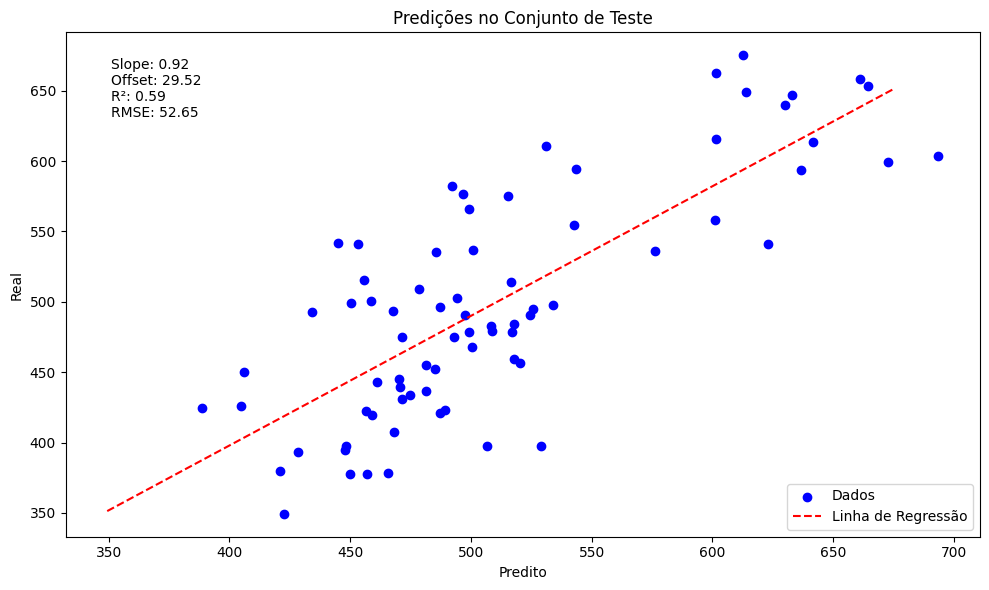

Resultados salvos em: random_forest_results.xlsx, na aba: SNV_FIRMEZA (N)


In [16]:
results_snv_firmeza = RFR(df_snv_cal.iloc[:, 6:], df_snv_cal['FIRMEZA (N)'].values, df_snv_val.iloc[:, 6:], df_snv_val['FIRMEZA (N)'].values, 'SNV', 'FIRMEZA (N)')
save_results('SNV', 'FIRMEZA (N)', results_snv_firmeza)


=== Training Metrics ===
Correlation coefficient: 0.9737
Mean absolute error: 0.4494
Root mean squared error: 0.7769
Relative absolute error: 18.8454
Root relative squared error: 24.6908
Total Number of Instances: 175.0000

=== Cross-Validation Metrics ===
Correlation coefficient: 0.7665
Mean absolute error: 1.2337
Root mean squared error: 2.0329
Relative absolute error: 51.7377
Root relative squared error: 64.6067
Total Number of Instances: 175.0000

=== Validation Metrics ===
Correlation coefficient: 0.8511
Mean absolute error: 0.9452
Root mean squared error: 1.3301
Relative absolute error: 47.8698
Root relative squared error: 55.4740
Total Number of Instances: 75.0000


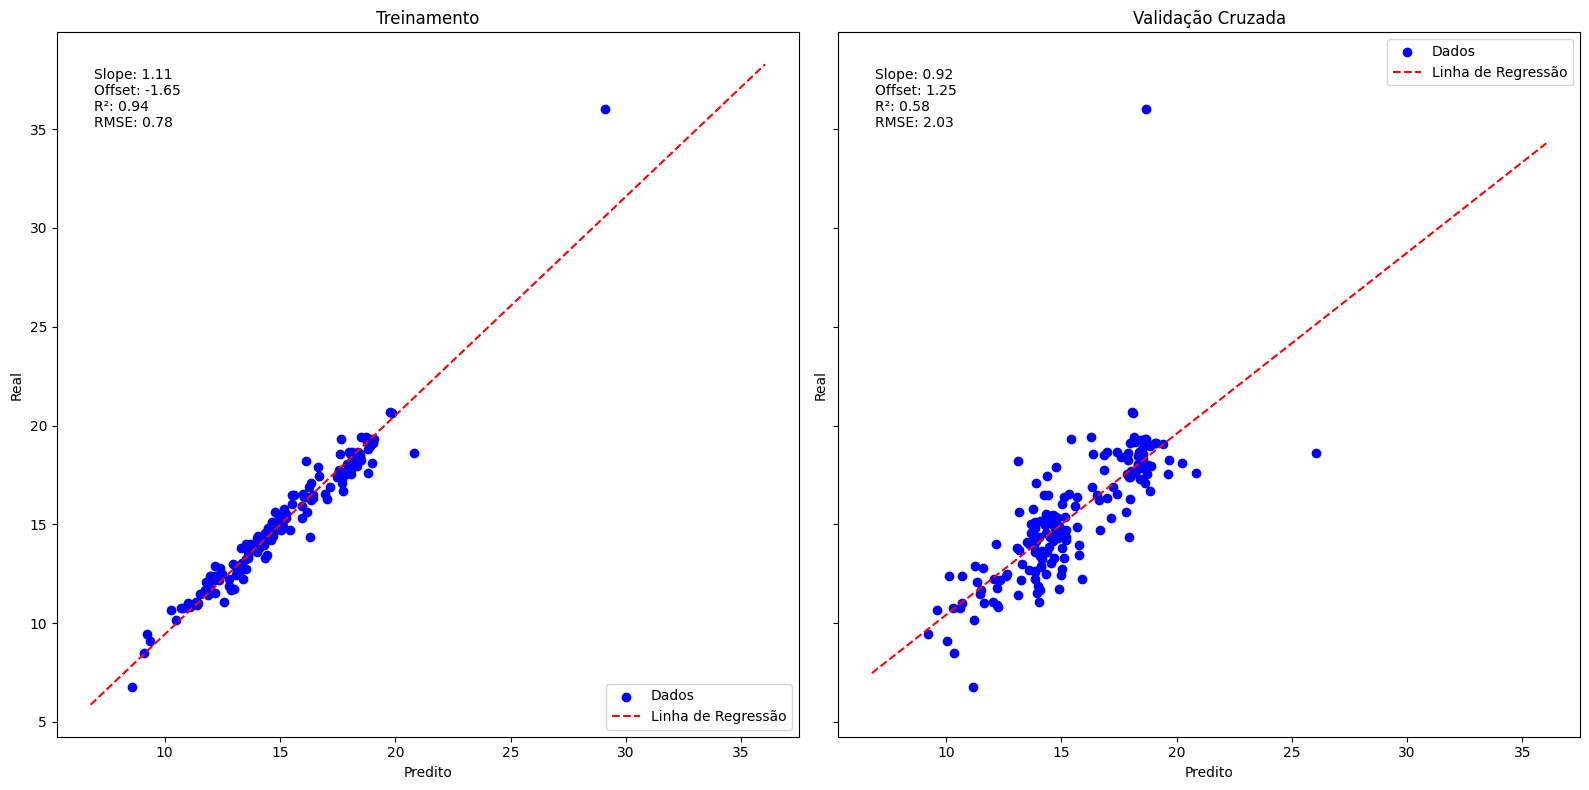

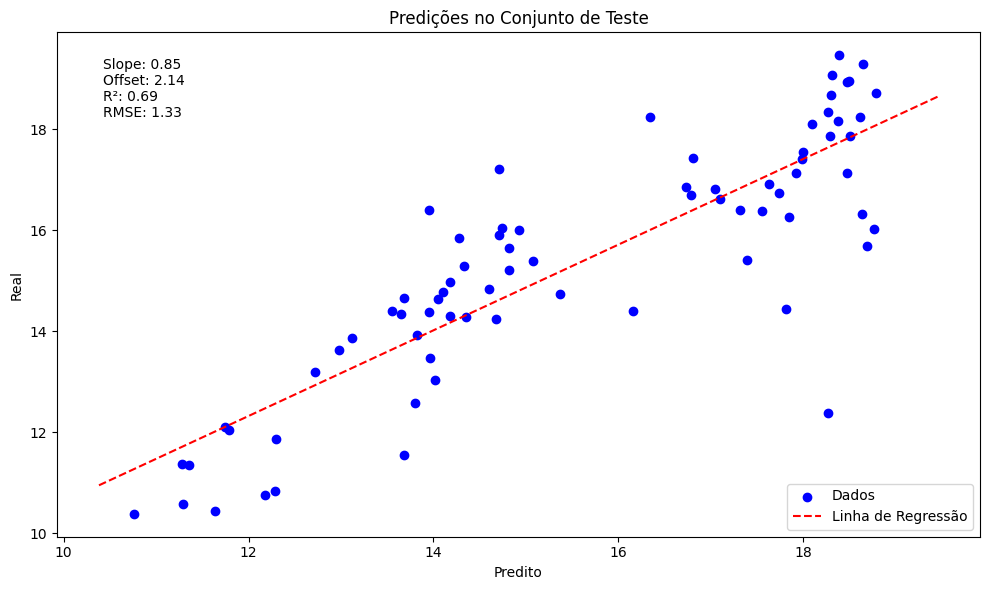

Resultados salvos em: random_forest_results.xlsx, na aba: SNV_UBS (%)


In [17]:
results_snv_ubs = RFR(df_snv_cal.iloc[:, 6:], df_snv_cal['UBS (%)'].values, df_snv_val.iloc[:, 6:], df_snv_val['UBS (%)'].values, 'SNV', 'UBS (%)')
save_results('SNV', 'UBS (%)', results_snv_ubs)

# SG - RFR


=== Training Metrics ===
Correlation coefficient: 0.9834
Mean absolute error: 0.3961
Root mean squared error: 0.5176
Relative absolute error: 17.9110
Root relative squared error: 19.4792
Total Number of Instances: 175.0000

=== Cross-Validation Metrics ===
Correlation coefficient: 0.8619
Mean absolute error: 1.0630
Root mean squared error: 1.3548
Relative absolute error: 48.0700
Root relative squared error: 50.9863
Total Number of Instances: 175.0000

=== Validation Metrics ===
Correlation coefficient: 0.8648
Mean absolute error: 0.8573
Root mean squared error: 1.0630
Relative absolute error: 49.9348
Root relative squared error: 50.5775
Total Number of Instances: 75.0000


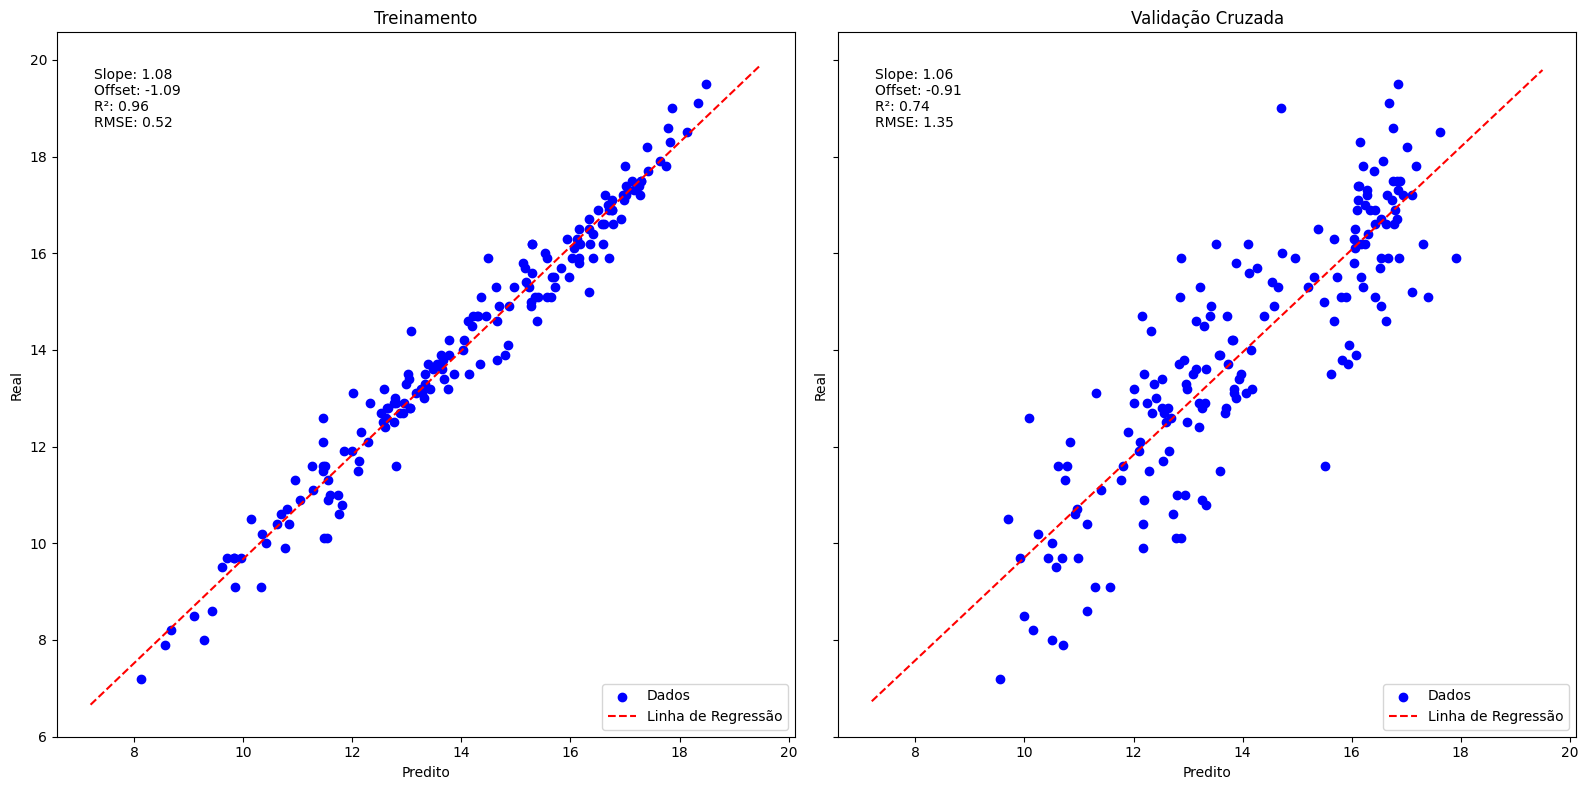

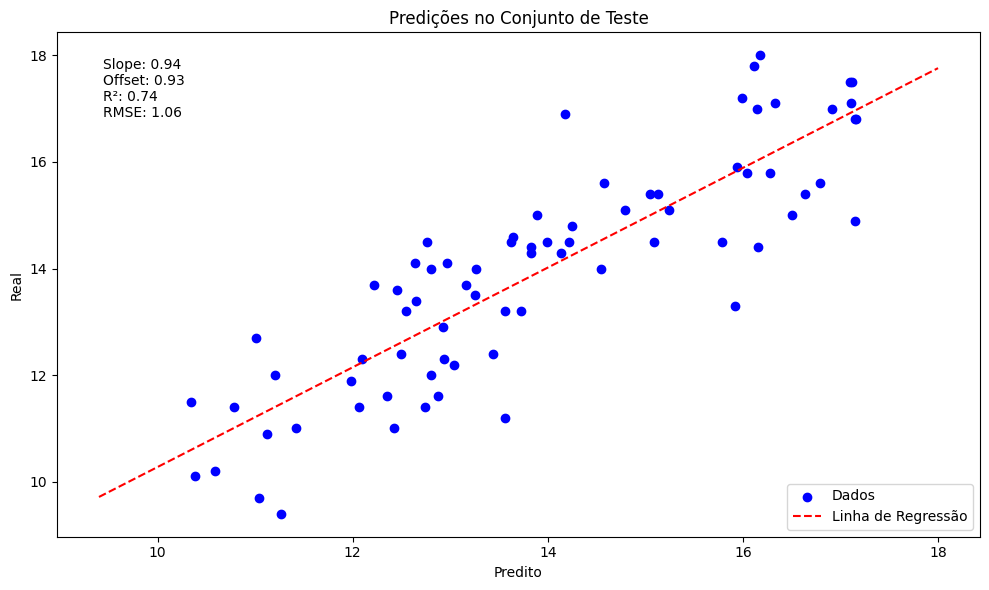

Resultados salvos em: random_forest_results.xlsx, na aba: SG_SST


In [18]:
results_sg_sst = RFR(df_sg_cal.iloc[:, 6:], df_sg_cal['SST'].values, df_sg_val.iloc[:, 6:], df_sg_val['SST'].values, 'SG', 'SST')
save_results('SG', 'SST', results_sg_sst)


=== Training Metrics ===
Correlation coefficient: 0.9712
Mean absolute error: 0.0960
Root mean squared error: 0.1661
Relative absolute error: 21.2185
Root relative squared error: 28.3075
Total Number of Instances: 175.0000

=== Cross-Validation Metrics ===
Correlation coefficient: 0.6802
Mean absolute error: 0.2518
Root mean squared error: 0.4302
Relative absolute error: 55.6444
Root relative squared error: 73.3405
Total Number of Instances: 175.0000

=== Validation Metrics ===
Correlation coefficient: 0.8030
Mean absolute error: 0.2057
Root mean squared error: 0.2750
Relative absolute error: 58.1597
Root relative squared error: 62.9505
Total Number of Instances: 75.0000


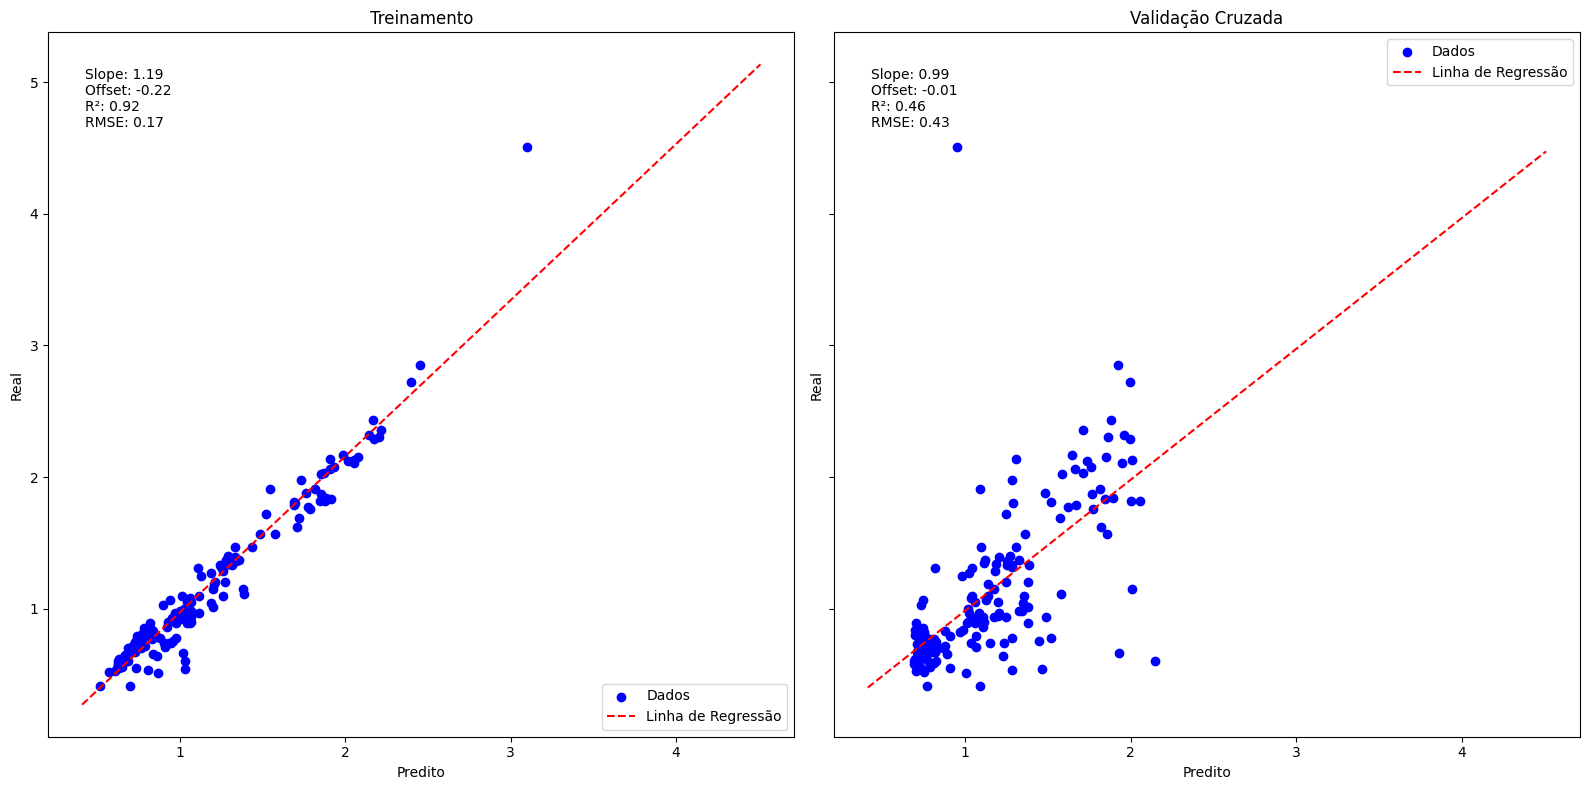

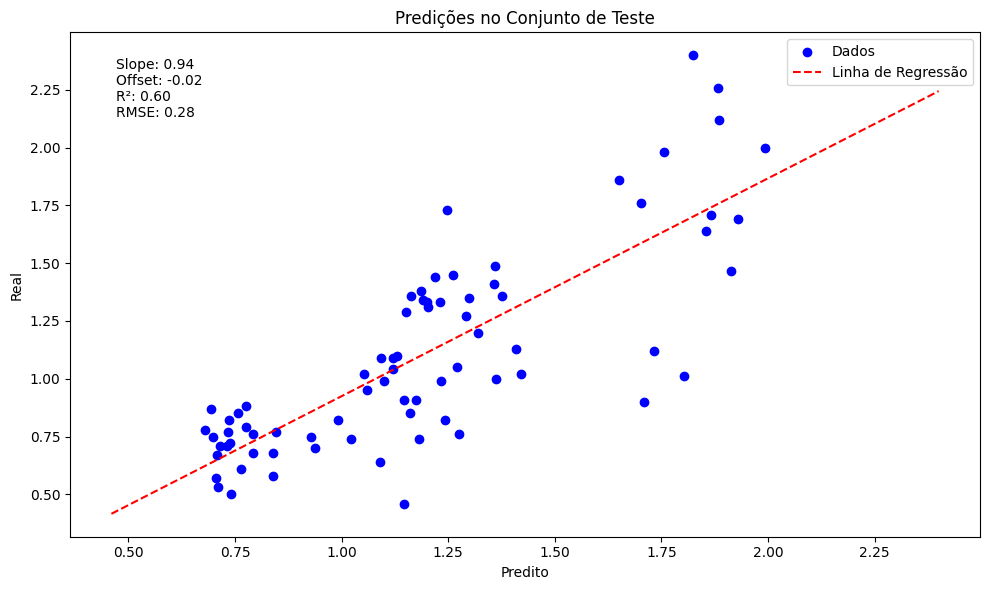

Resultados salvos em: random_forest_results.xlsx, na aba: SG_AT


In [19]:
results_sg_at = RFR(df_sg_cal.iloc[:, 6:], df_sg_cal['AT'].values, df_sg_val.iloc[:, 6:], df_sg_val['AT'].values, 'SG', 'AT')
save_results('SG', 'AT', results_sg_at)


=== Training Metrics ===
Correlation coefficient: 0.9742
Mean absolute error: 0.0539
Root mean squared error: 0.0916
Relative absolute error: 22.4496
Root relative squared error: 29.6449
Total Number of Instances: 175.0000

=== Cross-Validation Metrics ===
Correlation coefficient: 0.6183
Mean absolute error: 0.1411
Root mean squared error: 0.2429
Relative absolute error: 58.7434
Root relative squared error: 78.6237
Total Number of Instances: 175.0000

=== Validation Metrics ===
Correlation coefficient: 0.7853
Mean absolute error: 0.1179
Root mean squared error: 0.1638
Relative absolute error: 50.3008
Root relative squared error: 62.5731
Total Number of Instances: 75.0000


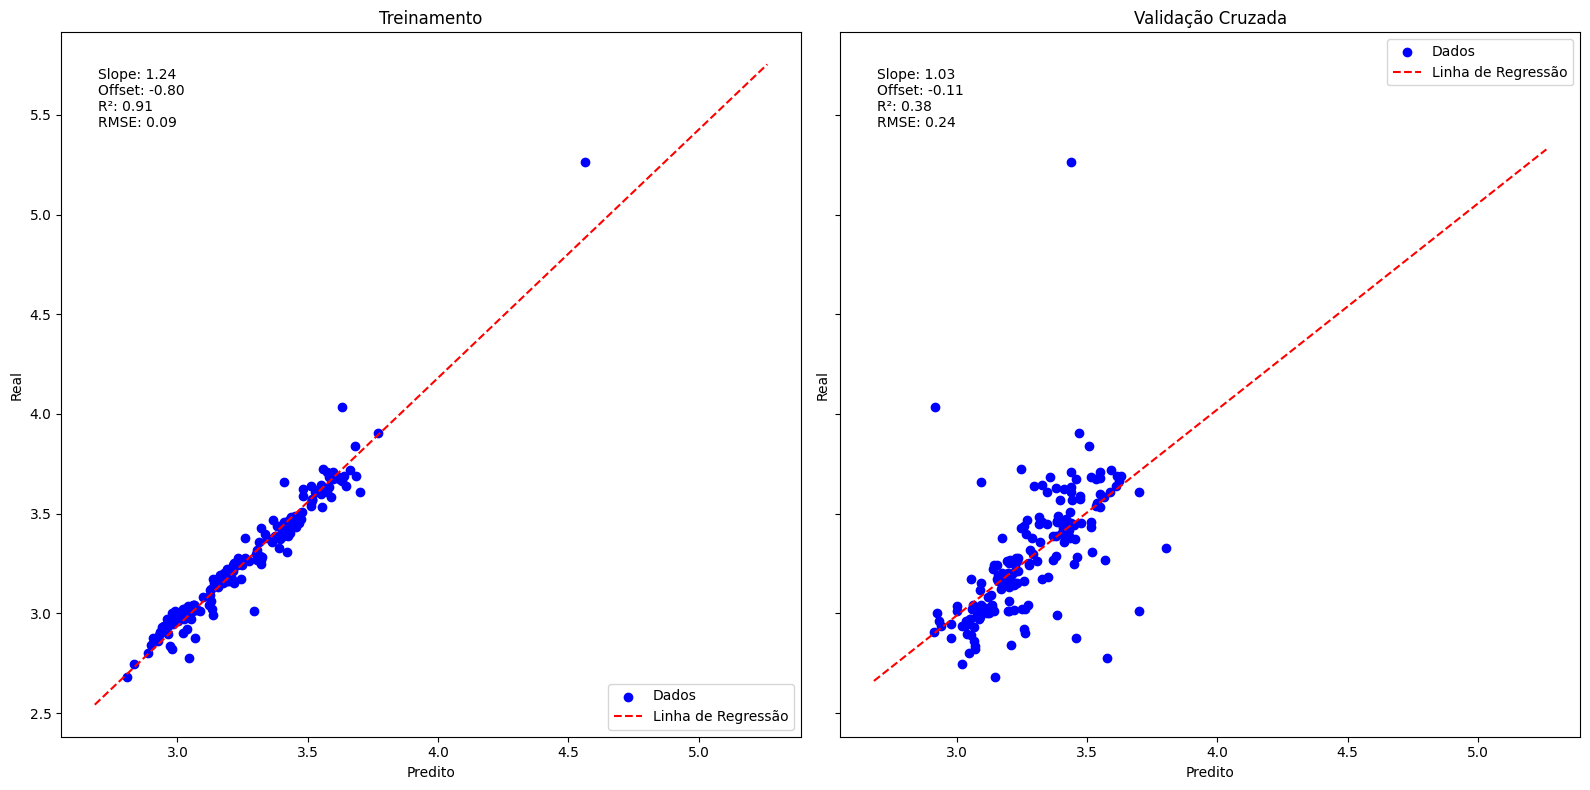

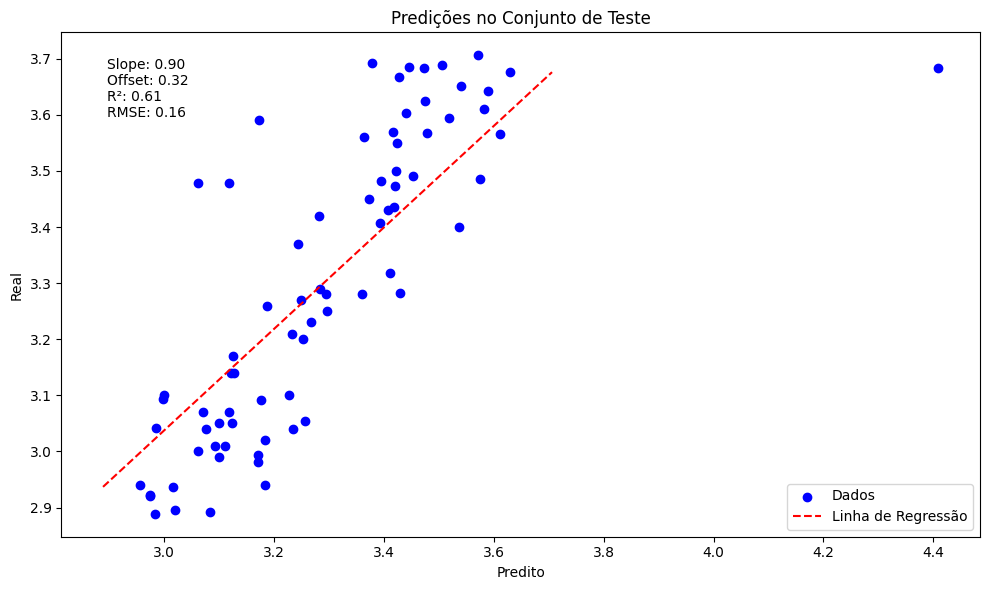

Resultados salvos em: random_forest_results.xlsx, na aba: SG_PH


In [20]:
results_sg_ph = RFR(df_sg_cal.iloc[:, 6:], df_sg_cal['PH'].values, df_sg_val.iloc[:, 6:], df_sg_val['PH'].values, 'SG', 'PH')
save_results('SG', 'PH', results_sg_ph)


=== Training Metrics ===
Correlation coefficient: 0.9683
Mean absolute error: 24.1932
Root mean squared error: 30.7414
Relative absolute error: 29.0532
Root relative squared error: 29.9124
Total Number of Instances: 175.0000

=== Cross-Validation Metrics ===
Correlation coefficient: 0.6481
Mean absolute error: 64.5603
Root mean squared error: 78.3725
Relative absolute error: 77.5295
Root relative squared error: 76.2589
Total Number of Instances: 175.0000

=== Validation Metrics ===
Correlation coefficient: 0.7391
Mean absolute error: 41.7659
Root mean squared error: 52.7670
Relative absolute error: 65.8098
Root relative squared error: 68.3055
Total Number of Instances: 75.0000


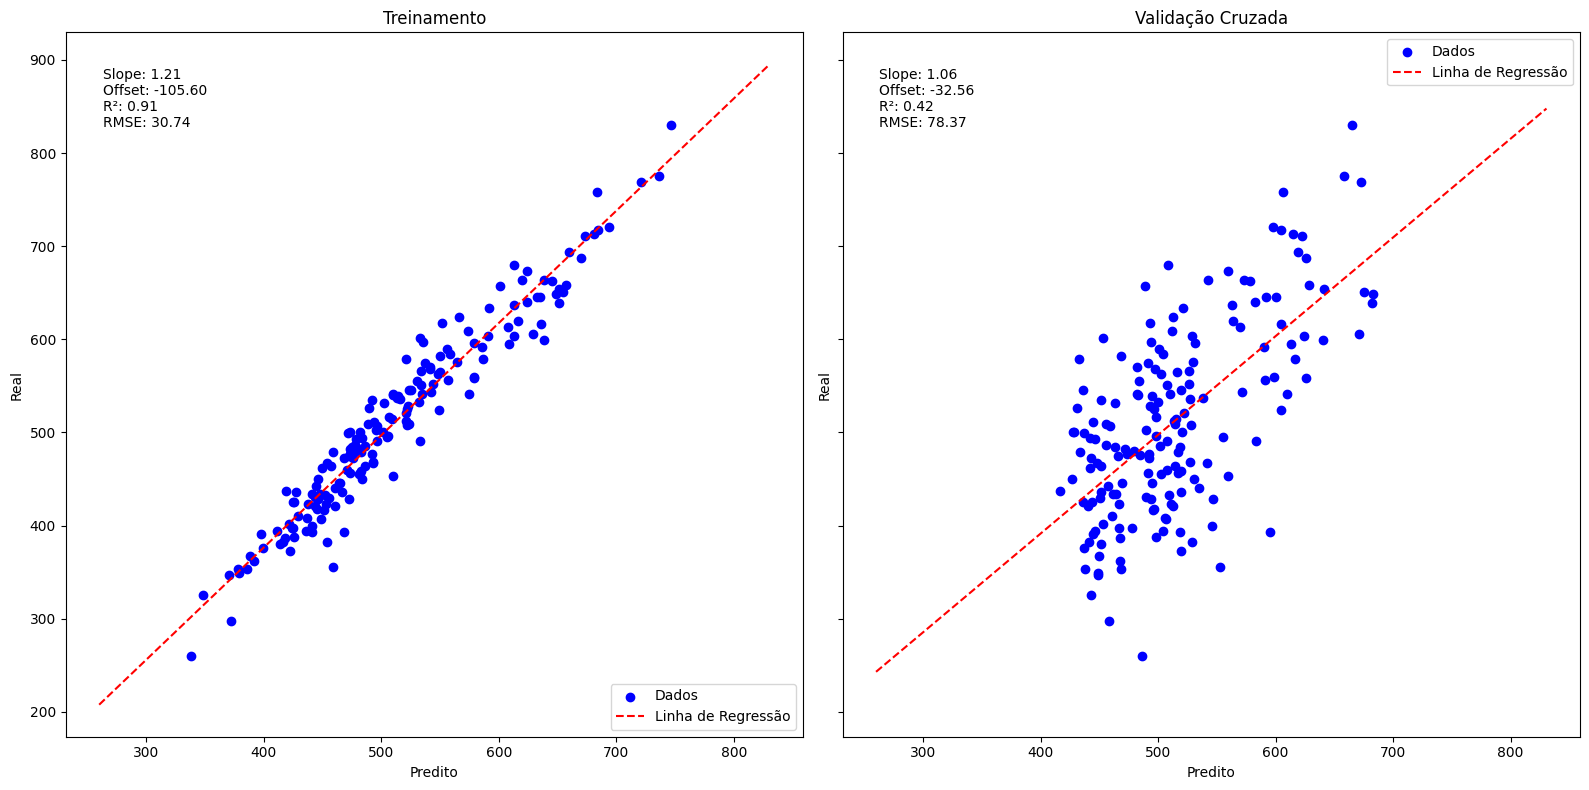

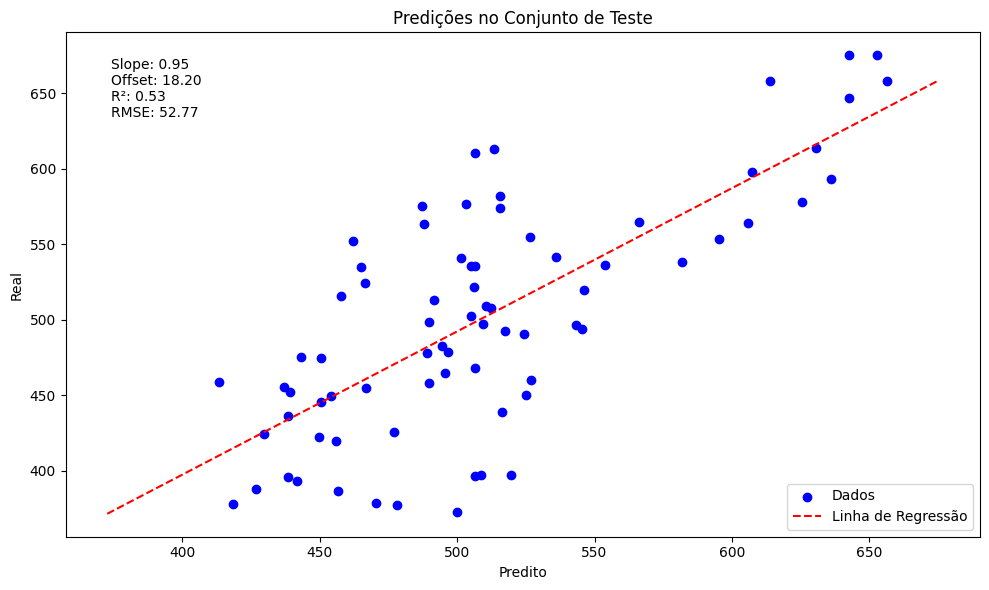

Resultados salvos em: random_forest_results.xlsx, na aba: SG_FIRMEZA (N)


In [21]:
results_sg_firmeza = RFR(df_sg_cal.iloc[:, 6:], df_sg_cal['FIRMEZA (N)'].values, df_sg_val.iloc[:, 6:], df_sg_val['FIRMEZA (N)'].values, 'SG', 'FIRMEZA (N)')
save_results('SG', 'FIRMEZA (N)', results_sg_firmeza)


=== Training Metrics ===
Correlation coefficient: 0.9780
Mean absolute error: 0.4143
Root mean squared error: 0.7537
Relative absolute error: 16.7783
Root relative squared error: 23.4325
Total Number of Instances: 175.0000

=== Cross-Validation Metrics ===
Correlation coefficient: 0.8147
Mean absolute error: 1.0972
Root mean squared error: 1.8762
Relative absolute error: 44.4352
Root relative squared error: 58.3308
Total Number of Instances: 175.0000

=== Validation Metrics ===
Correlation coefficient: 0.8905
Mean absolute error: 0.7784
Root mean squared error: 1.0200
Relative absolute error: 43.8696
Root relative squared error: 47.0706
Total Number of Instances: 75.0000


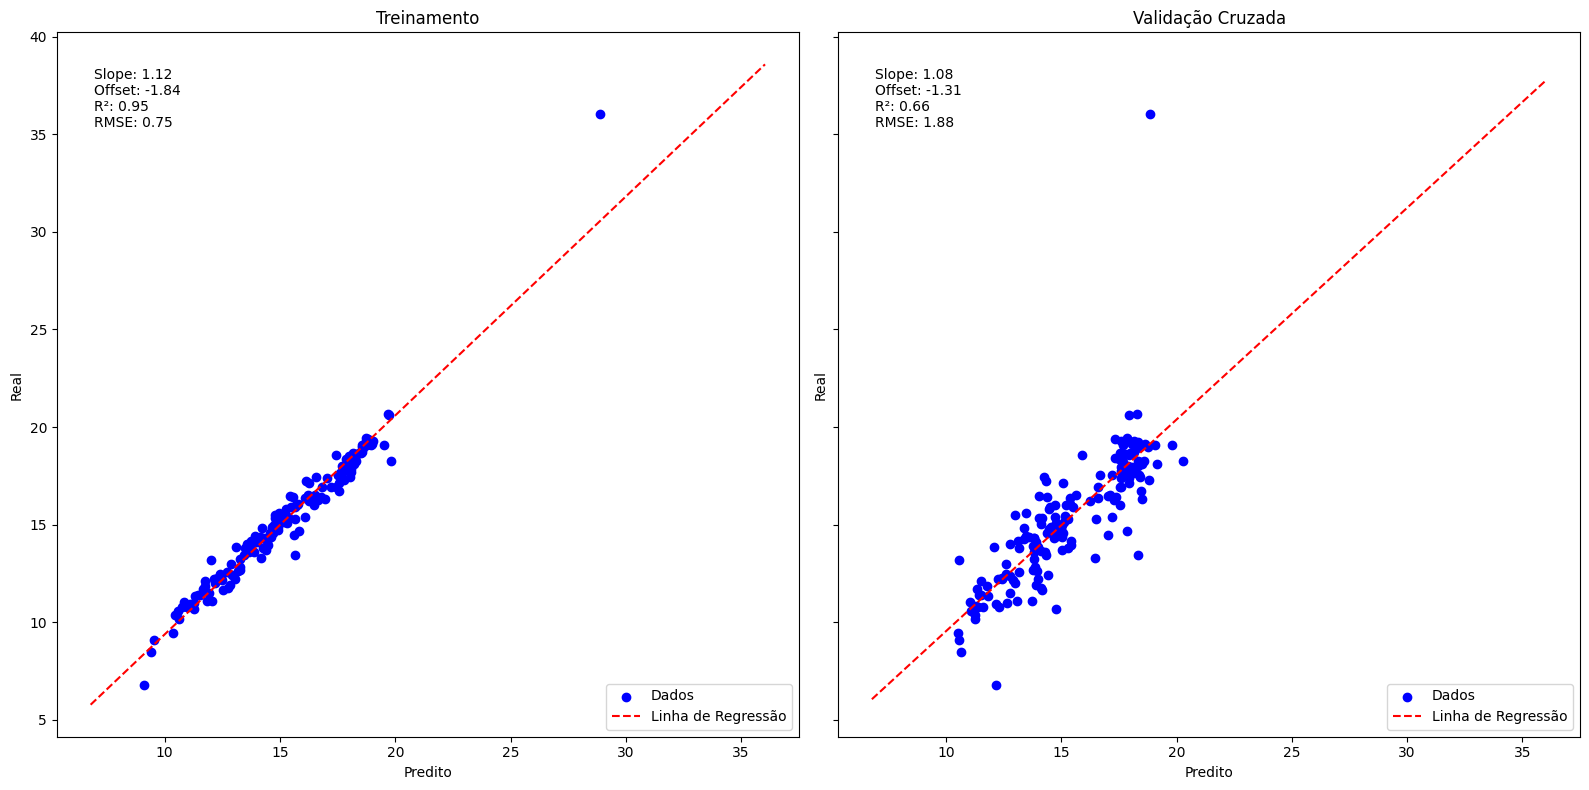

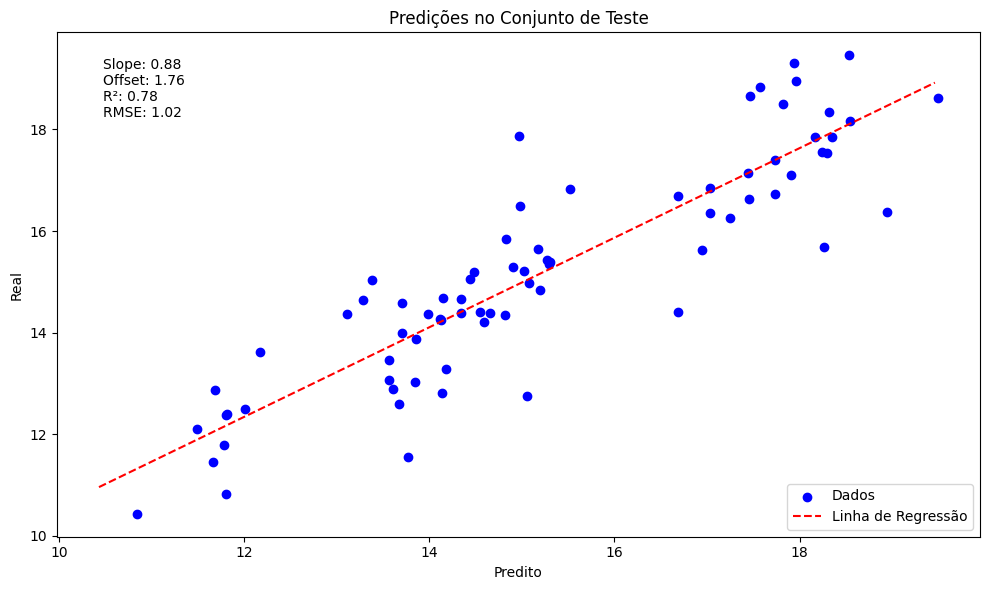

Resultados salvos em: random_forest_results.xlsx, na aba: SG_UBS (%)


In [22]:
results_sg_ubs = RFR(df_sg_cal.iloc[:, 6:], df_sg_cal['UBS (%)'].values, df_sg_val.iloc[:, 6:], df_sg_val['UBS (%)'].values, 'SG', 'UBS (%)')
save_results('SG', 'UBS (%)', results_sg_ubs)